<a href="https://colab.research.google.com/github/meetjoshi00/Performance-Prediction-in-F1/blob/main/Performance_Prediction_in_F1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Setup

Setting up and Installing Fast F1 API:

In [4]:
%%capture
pip install fastf1

In [5]:
import fastf1
import fastf1.plotting
import pandas as pd
from google.colab import drive, userdata
import zipfile
import os
import shap
import time
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder

In [6]:
# Mounting Google Drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:
working_dir = '/content/drive/My Drive/Performance Prediction in F1/f1_cache'
os.chdir(working_dir)

In [8]:
print(os.getcwd())

/content/drive/My Drive/Performance Prediction in F1/f1_cache


Setting up cache path. This will enable to load the data from cache rather than hitting API again and again. Hence, avoiding costly data pulling requests to setup the \required dataset.

In [ ]:
cache_path = os.path.join(working_dir, 'f1_cache')
if not os.path.exists(cache_path):
    os.makedirs(cache_path)

# Enable FastF1 cache
fastf1.Cache.enable_cache(cache_path)

Dividing Training and testing dataset. Taking 2022 to 2024 races as training data. While 2025 race data is treated as testing set.

In [ ]:
training_years = [2022, 2023, 2024]
testing_years = [2025]
session_types = ['R', 'Q']  # R = Race and Q = Qualifying

In [ ]:
# Step 3: Helper function to check if session is cached
def is_cached(year, gp_round, session_name):
    try:
        _ = fastf1.get_session(year, gp_round, session_name)
        return True
    except Exception:
        return False

Below is the code which was used to pull race data from Fast F1 API. It has been commented out as I have used another optimal approach to fetch the F1 race data from Fast F1 API

In [ ]:
# def cache_sessions(years, use_for="training"):
#     for year in years:
#         print(f"\n Year: {year} ({use_for})")
#         try:
#             schedule = fastf1.get_event_schedule(year)
#         except Exception as e:
#             print(f"Could not retrieve schedule for {year}: {e}")
#             continue

#         for i, row in schedule.iterrows():
#             rnd = int(row['RoundNumber'])
#             for sess_type in session_types:
#                 try:
#                     session = fastf1.get_session(year, rnd, sess_type)
#                     session.load()  # Loads and caches
#                     print(f"Cached {year} Round {rnd} ({sess_type}) - {row['EventName']}")
#                 except Exception as e:
#                     print(f"Skipped {year} R{rnd} {sess_type}: {e}")
#                 time.sleep(5)  # Delay to prevent rate limiting

# # Step 5: Run caching
# cache_sessions(training_years, use_for="training")
# cache_sessions(testing_years, use_for="testing")

# print("\n All target sessions processed.")

In [ ]:
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.width', None)        # Don't wrap lines (if applicable)
# pd.reset_option('display.max_columns')
# pd.reset_option('display.width')

In [ ]:
# # Load the 2025 Bahrain GP Race session
# session = fastf1.get_session(2025,1,'R')
# session.load()

## Loading data

There is no need to run the cells fetching data from FastF1 API, instead just  run the cells which are extracting data from csv files. After fetching data from API, I have stored it in csv files. I have given the access of the required csv files. Moreover, I have attached csv in the submitted github repo.

Below code was used to fetch the F1 race data from Fast F1 API. Below is the most optimal version of the code. Have included time delay to avoid hitting api limit of 500 limit/hour.

In [ ]:
import time
from datetime import datetime, timezone

def load_cached_laps(years, session_type='R', max_rounds=24, delay_sec=8):
    """
    Loads cached lap data for the specified years and session type.
    Skips future rounds (with no data) and respects API rate limits by adding delay.

    Parameters:
        years (list): List of race years to load
        session_type (str): 'R' for race, 'Q' for qualifying
        max_rounds (int): Max number of rounds to attempt per year
        delay_sec (int): Seconds to delay between API calls (rate limiting)

    Returns:
        pd.DataFrame: Combined laps data from all available sessions
    """
    all_laps = []

    for year in years:
        for rnd in range(1, max_rounds + 1):
            try:
                session = fastf1.get_session(year, rnd, session_type)

                # Only attempt loading if event has already occurred
                event_date = pd.to_datetime(session.event['Session5Date'], utc=True)
                if event_date > pd.Timestamp.now(tz=timezone.utc):
                    print(f"⏩ Skipping {year} Round {rnd} - Event not held yet")
                    continue

                session.load(telemetry=False, weather=False, messages=False)

                if session.laps.empty:
                    print(f"⚠️ No lap data for {year} Round {rnd}, skipping...")
                    continue

                laps = session.laps.copy()
                laps['Year'] = year
                laps['Round'] = rnd
                laps['RaceName'] = session.event['EventName']
                laps['DriverNumber'] = laps['DriverNumber'].astype(str)

                all_laps.append(laps)
                print(f"Loaded {year} Round {rnd} - {session.event['EventName']}")

            except Exception as e:
                print(f"Skipped {year} Round {rnd}: {e}")

            time.sleep(delay_sec)

    return pd.concat(all_laps, ignore_index=True) if all_laps else pd.DataFrame()


Classifying the training data using below code. As mentioned earlier, have taken only 2022 to 2024 race data for training dataset.

In [ ]:
train_laps = load_cached_laps([2022, 2023, 2024], session_type='R')



core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2022 Round 1 - Bahrain Grand Prix


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

✅ Loaded 2022 Round 2 - Saudi Arabian Grand Prix


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

✅ Loaded 2022 Round 3 - Australian Grand Prix


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data

✅ Loaded 2022 Round 4 - Emilia Romagna Grand Prix


core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

✅ Loaded 2022 Round 5 - Miami Grand Prix


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2022 Round 6 - Spanish Grand Prix


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           

✅ Loaded 2022 Round 7 - Monaco Grand Prix


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

✅ Loaded 2022 Round 8 - Azerbaijan Grand Prix


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2022 Round 9 - Canadian Grand Prix


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2022 Round 10 - British Grand Prix


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2022 Round 11 - Austrian Grand Prix


core           INFO 	Loading data for French Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for French Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           

✅ Loaded 2022 Round 12 - French Grand Prix


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

✅ Loaded 2022 Round 13 - Hungarian Grand Prix


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2022 Round 14 - Belgian Grand Prix


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

✅ Loaded 2022 Round 15 - Dutch Grand Prix


core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2022 Round 16 - Italian Grand Prix


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

✅ Loaded 2022 Round 17 - Singapore Grand Prix


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2022 Round 18 - Japanese Grand Prix


core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

✅ Loaded 2022 Round 19 - United States Grand Prix


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core 

✅ Loaded 2022 Round 20 - Mexico City Grand Prix


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

✅ Loaded 2022 Round 21 - São Paulo Grand Prix


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core     

✅ Loaded 2022 Round 22 - Abu Dhabi Grand Prix
⛔ Skipped 2022 Round 23: Invalid round: 23
⛔ Skipped 2022 Round 24: Invalid round: 24


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2023 Round 1 - Bahrain Grand Prix


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

✅ Loaded 2023 Round 2 - Saudi Arabian Grand Prix


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:24:05.036' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:24:06.409' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:24:07.342' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:24:07.559' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:01:16.239' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached da

✅ Loaded 2023 Round 3 - Australian Grand Prix


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

✅ Loaded 2023 Round 4 - Azerbaijan Grand Prix


core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core           IN

✅ Loaded 2023 Round 5 - Miami Grand Prix


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:53:44.819' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_d

✅ Loaded 2023 Round 6 - Monaco Grand Prix


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2023 Round 7 - Spanish Grand Prix


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2023 Round 8 - Canadian Grand Prix


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2023 Round 9 - Austrian Grand Prix


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:18.651' in Ergastresponse.
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app

✅ Loaded 2023 Round 10 - British Grand Prix


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:58:20.590' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data. Loading data...
_api           INFO 	Fetching session status data...
INFO:fastf1.api:Fetching session status data...
req            INFO 	Data has been writ

✅ Loaded 2023 Round 11 - Hungarian Grand Prix


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2023 Round 12 - Belgian Grand Prix


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

✅ Loaded 2023 Round 13 - Dutch Grand Prix


core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2023 Round 14 - Italian Grand Prix


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:58:21.514' in Ergastresponse.
req            INFO 	No cached data found for session_status_da

✅ Loaded 2023 Round 15 - Singapore Grand Prix


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status

✅ Loaded 2023 Round 16 - Japanese Grand Prix


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Qatar Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

✅ Loaded 2023 Round 17 - Qatar Grand Prix


core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

✅ Loaded 2023 Round 18 - United States Grand Prix


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_

✅ Loaded 2023 Round 19 - Mexico City Grand Prix


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_stat

✅ Loaded 2023 Round 20 - São Paulo Grand Prix


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Las Vegas Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:54:30.642' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:35.501' in

✅ Loaded 2023 Round 21 - Las Vegas Grand Prix


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:59:48.299' in Ergastresponse.
req            INFO 	No cached data found for session_status_da

✅ Loaded 2023 Round 22 - Abu Dhabi Grand Prix
⛔ Skipped 2023 Round 23: Invalid round: 23
⛔ Skipped 2023 Round 24: Invalid round: 24


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2024 Round 1 - Bahrain Grand Prix


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

✅ Loaded 2024 Round 2 - Saudi Arabian Grand Prix


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:57:37.891' in Ergastresponse.
req            INFO 	No cached data found for session_status_

✅ Loaded 2024 Round 3 - Australian Grand Prix


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status

✅ Loaded 2024 Round 4 - Japanese Grand Prix


core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2024 Round 5 - Chinese Grand Prix


core           INFO 	Loading data for Miami Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Miami Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

✅ Loaded 2024 Round 6 - Miami Grand Prix


core           INFO 	Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Emilia Romagna Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for se

✅ Loaded 2024 Round 7 - Emilia Romagna Grand Prix


core           INFO 	Loading data for Monaco Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Monaco Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_dat

✅ Loaded 2024 Round 8 - Monaco Grand Prix


core           INFO 	Loading data for Canadian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Canadian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status

✅ Loaded 2024 Round 9 - Canadian Grand Prix


core           INFO 	Loading data for Spanish Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Spanish Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2024 Round 10 - Spanish Grand Prix


core           INFO 	Loading data for Austrian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Austrian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:52:13.256' in Ergastresponse.
req            INFO 	No cached data found for session_status_data

✅ Loaded 2024 Round 11 - Austrian Grand Prix


core           INFO 	Loading data for British Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for British Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2024 Round 12 - British Grand Prix


core           INFO 	Loading data for Hungarian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Hungarian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_stat

✅ Loaded 2024 Round 13 - Hungarian Grand Prix


core           INFO 	Loading data for Belgian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Belgian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:59:59.474' in Ergastresponse.
req            INFO 	No cached data found for session_status_data. 

✅ Loaded 2024 Round 14 - Belgian Grand Prix


core           INFO 	Loading data for Dutch Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Dutch Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

✅ Loaded 2024 Round 15 - Dutch Grand Prix


core           INFO 	Loading data for Italian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Italian Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_d

✅ Loaded 2024 Round 16 - Italian Grand Prix


core           INFO 	Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Azerbaijan Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:55:43.191' in Ergastresponse.
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:55:43.761' 

✅ Loaded 2024 Round 17 - Azerbaijan Grand Prix


core           INFO 	Loading data for Singapore Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Singapore Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:55:59.335' in Ergastresponse.
req            INFO 	No cached data found for session_status_da

✅ Loaded 2024 Round 18 - Singapore Grand Prix


core           INFO 	Loading data for United States Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for United States Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for sess

✅ Loaded 2024 Round 19 - United States Grand Prix


core           INFO 	Loading data for Mexico City Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Mexico City Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_

✅ Loaded 2024 Round 20 - Mexico City Grand Prix


core           INFO 	Loading data for São Paulo Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for São Paulo Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_stat

✅ Loaded 2024 Round 21 - São Paulo Grand Prix


core           INFO 	Loading data for Las Vegas Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Las Vegas Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_stat

✅ Loaded 2024 Round 22 - Las Vegas Grand Prix


core           INFO 	Loading data for Qatar Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Qatar Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for session_status_data. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_status_data.

✅ Loaded 2024 Round 23 - Qatar Grand Prix


core           INFO 	Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Abu Dhabi Grand Prix - Race [v3.5.3]
req            INFO 	No cached data found for session_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for session_info. Loading data...
_api           INFO 	Fetching session info data...
INFO:fastf1.api:Fetching session info data...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
req            INFO 	No cached data found for driver_info. Loading data...
INFO:fastf1.fastf1.req:No cached data found for driver_info. Loading data...
_api           INFO 	Fetching driver list...
INFO:fastf1.api:Fetching driver list...
req            INFO 	Data has been written to cache!
INFO:fastf1.fastf1.req:Data has been written to cache!
DEBUG:fastf1.ergast:Failed to parse timestamp '-1:58:03.658' in Ergastresponse.
req            INFO 	No cached data found for session_status_da

✅ Loaded 2024 Round 24 - Abu Dhabi Grand Prix


Classifying the testing data using below code. As mentioned earlier, have taken only 2025 race data for testing dataset. Model will be tested on the below data which will be completely new for the model.

In [ ]:
test_laps = load_cached_laps([2025], session_type='R')


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

✅ Loaded 2025 Round 1 - Australian Grand Prix


core           INFO 	Loading data for Chinese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Chinese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2025 Round 2 - Chinese Grand Prix


core           INFO 	Loading data for Japanese Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Japanese Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core       

✅ Loaded 2025 Round 3 - Japanese Grand Prix


core           INFO 	Loading data for Bahrain Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Bahrain Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core         

✅ Loaded 2025 Round 4 - Bahrain Grand Prix


core           INFO 	Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Saudi Arabian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
c

✅ Loaded 2025 Round 5 - Saudi Arabian Grand Prix
⏩ Skipping 2025 Round 6 - Event not held yet
⏩ Skipping 2025 Round 7 - Event not held yet
⏩ Skipping 2025 Round 8 - Event not held yet
⏩ Skipping 2025 Round 9 - Event not held yet
⏩ Skipping 2025 Round 10 - Event not held yet
⏩ Skipping 2025 Round 11 - Event not held yet
⏩ Skipping 2025 Round 12 - Event not held yet
⏩ Skipping 2025 Round 13 - Event not held yet
⏩ Skipping 2025 Round 14 - Event not held yet
⏩ Skipping 2025 Round 15 - Event not held yet
⏩ Skipping 2025 Round 16 - Event not held yet
⏩ Skipping 2025 Round 17 - Event not held yet
⏩ Skipping 2025 Round 18 - Event not held yet
⏩ Skipping 2025 Round 19 - Event not held yet
⏩ Skipping 2025 Round 20 - Event not held yet
⏩ Skipping 2025 Round 21 - Event not held yet
⏩ Skipping 2025 Round 22 - Event not held yet
⏩ Skipping 2025 Round 23 - Event not held yet
⏩ Skipping 2025 Round 24 - Event not held yet


In [10]:
# Define path
save_path = '/content/drive/My Drive/Performance Prediction in F1/'

Rather than hitting the API everytime which is very costly from data extraction perspective. I have saved the race data fetched from F1 API in csv format, and then have loaded the data from csv file to process further.

In [ ]:
# # Save DataFrames to CSV
# train_laps.to_csv(f"{save_path}train_laps.csv", index=False)
# test_laps.to_csv(f"{save_path}test_laps.csv", index=False)

In [11]:
# Re-load the CSVs into DataFrames (if needed later)
train_laps = pd.read_csv(f"{save_path}train_laps.csv")
test_laps = pd.read_csv(f"{save_path}test_laps.csv")


In [12]:
train_laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year', 'Round', 'RaceName'],
      dtype='object')

In [13]:
test_laps.columns

Index(['Time', 'Driver', 'DriverNumber', 'LapTime', 'LapNumber', 'Stint',
       'PitOutTime', 'PitInTime', 'Sector1Time', 'Sector2Time', 'Sector3Time',
       'Sector1SessionTime', 'Sector2SessionTime', 'Sector3SessionTime',
       'SpeedI1', 'SpeedI2', 'SpeedFL', 'SpeedST', 'IsPersonalBest',
       'Compound', 'TyreLife', 'FreshTyre', 'Team', 'LapStartTime',
       'LapStartDate', 'TrackStatus', 'Position', 'Deleted', 'DeletedReason',
       'FastF1Generated', 'IsAccurate', 'Year', 'Round', 'RaceName'],
      dtype='object')

# Prediction 1: Predicting Striking Distance of Chaser to Leader

## Feature Engineering

Laps Remaning and Lap Ratio is being calulated below

In [14]:
def add_lap_progression_features(laps_df):
    """
    Adds LapsRemaining and LapRatio to laps DataFrame.
    """
    laps_df = laps_df.copy()

    # Compute max lap per race
    max_laps = (
        laps_df.groupby(['Year', 'Round'])['LapNumber']
        .max()
        .reset_index()
        .rename(columns={'LapNumber': 'MaxLap'})
    )


    laps_df = laps_df.merge(max_laps, on=['Year', 'Round'], how='left')

    laps_df['LapsRemaining'] = laps_df['MaxLap'] - laps_df['LapNumber']
    laps_df['LapRatio'] = laps_df['LapNumber'] / laps_df['MaxLap']

    return laps_df


In [15]:
train_laps = add_lap_progression_features(train_laps)

In [16]:
test_laps = add_lap_progression_features(test_laps)

In [17]:
train_laps.head(2)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Deleted,DeletedReason,FastF1Generated,IsAccurate,Year,Round,RaceName,MaxLap,LapsRemaining,LapRatio
0,0 days 01:04:15.340000,VER,1,0 days 00:01:40.236000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:42.325000,...,NaN,NaN,False,False,2022,1,Bahrain Grand Prix,57.0,56.0,0.017544
1,0 days 01:05:53.220000,VER,1,0 days 00:01:37.880000,2.0,1.0,NaN,NaN,0 days 00:00:31.285000,0 days 00:00:42.269000,...,NaN,NaN,False,True,2022,1,Bahrain Grand Prix,57.0,55.0,0.035088


In [ ]:
# test_laps[(test_laps['Round'].isin([2])) & ((test_laps['Position'] == 1.0) | (test_laps['Position'] == 2.0)) & (test_laps['Driver'] == 'NOR')]

In [18]:
# train_laps[['Driver', 'LapNumber', 'MaxLap', 'LapsRemaining', 'LapRatio']].head(5)
test_laps.head(2)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Deleted,DeletedReason,FastF1Generated,IsAccurate,Year,Round,RaceName,MaxLap,LapsRemaining,LapRatio
0,0 days 01:13:00.002000,VER,1,0 days 00:01:59.392000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:20.705000,...,NaN,NaN,False,False,2025,1,Australian Grand Prix,57.0,56.0,0.017544
1,0 days 01:15:49.358000,VER,1,NaN,2.0,1.0,NaN,0 days 01:15:38.205000,0 days 00:00:58.141000,0 days 00:00:37.976000,...,NaN,NaN,False,False,2025,1,Australian Grand Prix,57.0,55.0,0.035088


Get unique TrackStatus values and their counts:

In [19]:

track_status_counts = test_laps['TrackStatus'].value_counts().sort_index()


print("Unique TrackStatus values and their counts:")
print(track_status_counts)


Unique TrackStatus values and their counts:
TrackStatus
1      4498
4       297
12       78
14       20
21       26
24        3
41       85
124      70
Name: count, dtype: int64


In [20]:
train_laps = train_laps[train_laps['TrackStatus'] == 1].copy()
test_laps = test_laps[test_laps['TrackStatus'] == 1].copy()

In [21]:
train_laps.shape

(66768, 37)

In [22]:
test_laps.shape

(4498, 37)

## Setting up chaser and leader data using below code. Giving labels - who is chased by whom. Below code also includes setting up other necessary data which will be computed further down, data such as lap time, gap, tyre life, and compound metrics:

In [23]:
def extract_p1_p2_chase_laps(laps_df):
    """
    Extract lap-level data where P2 is chasing P1.
    Includes lap time, tyre life, compound, and gap-related metrics.
    Handles string-based LapTime values gracefully.
    """
    import pandas as pd  # Ensure pandas is available

    chase_data = []
    clean_laps = laps_df[laps_df['LapTime'].notna()].copy()

    for (year, rnd), race_laps in clean_laps.groupby(['Year', 'Round']):
        for lap_number in sorted(race_laps['LapNumber'].unique()):
            lap_group = race_laps[race_laps['LapNumber'] == lap_number]

            p1 = lap_group[lap_group['Position'] == 1]
            p2 = lap_group[lap_group['Position'] == 2]

            if len(p1) == 1 and len(p2) == 1:
                p1 = p1.iloc[0]
                p2 = p2.iloc[0]

                # Safely convert LapTime to timedelta
                try:
                    p1_laptime = pd.to_timedelta(p1['LapTime']) if pd.notnull(p1['LapTime']) else None
                    p2_laptime = pd.to_timedelta(p2['LapTime']) if pd.notnull(p2['LapTime']) else None
                except Exception:
                    p1_laptime, p2_laptime = None, None

                gap = (p2_laptime - p1_laptime).total_seconds() if p1_laptime and p2_laptime else None
                laptime_delta = (p1_laptime - p2_laptime).total_seconds() if p1_laptime and p2_laptime else None

                leader_tyrelife = p1['TyreLife'] if pd.notnull(p1['TyreLife']) else None
                chaser_tyrelife = p2['TyreLife'] if pd.notnull(p2['TyreLife']) else None
                tyrelife_delta = chaser_tyrelife - leader_tyrelife if leader_tyrelife and chaser_tyrelife else None

                chase_data.append({
                    'Year': year,
                    'Round': rnd,
                    'RaceName': p1['RaceName'],
                    'LapNumber': lap_number,

                    'Leader': p1['Driver'],
                    'Chaser': p2['Driver'],

                    'gap': gap,

                    'LeaderLapTime': p1_laptime.total_seconds() if p1_laptime else None,
                    'ChaserLapTime': p2_laptime.total_seconds() if p2_laptime else None,
                    'LapTimeDelta': laptime_delta,

                    'LeaderTyreLife': leader_tyrelife,
                    'ChaserTyreLife': chaser_tyrelife,
                    'TyreLifeDelta': tyrelife_delta,

                    'LeaderCompound': p1['Compound'] if pd.notnull(p1['Compound']) else None,
                    'ChaserCompound': p2['Compound'] if pd.notnull(p2['Compound']) else None,

                    'avg_delta_3': None,
                    'LapTime': p2_laptime.total_seconds() if p2_laptime else None,
                    'TyreLife': chaser_tyrelife,
                    'LapsRemaining': p2['LapsRemaining'],
                    'LapRatio': p2['LapRatio'],
                })

    return pd.DataFrame(chase_data)


In [24]:
train_laps.dtypes

,0
Time,object
Driver,object
DriverNumber,int64
LapTime,object
LapNumber,float64
Stint,float64
PitOutTime,object
PitInTime,object
Sector1Time,object
Sector2Time,object


In [25]:
train_laps.head(1)

,Time,Driver,DriverNumber,LapTime,LapNumber,Stint,PitOutTime,PitInTime,Sector1Time,Sector2Time,...,Deleted,DeletedReason,FastF1Generated,IsAccurate,Year,Round,RaceName,MaxLap,LapsRemaining,LapRatio
0,0 days 01:04:15.340000,VER,1,0 days 00:01:40.236000,1.0,1.0,NaN,NaN,NaN,0 days 00:00:42.325000,...,NaN,NaN,False,False,2022,1,Bahrain Grand Prix,57.0,56.0,0.017544


In [26]:
p1_p2_df = extract_p1_p2_chase_laps(train_laps)



In [27]:
test_p1_p2_df = extract_p1_p2_chase_laps(test_laps)


## Feature Encoding: Assigning tire compounds with appropriate vlaue so that they are raedy to be processed for ML modelling

In [28]:
compound_map = {
    'SOFT': 1,
    'MEDIUM': 2,
    'HARD': 3,
    'INTERMEDIATE': 4,
    'WET': 5
}



In [29]:
p1_p2_df['LeaderCompoundEncoded'] = p1_p2_df['LeaderCompound'].map(compound_map)
p1_p2_df['ChaserCompoundEncoded'] = p1_p2_df['ChaserCompound'].map(compound_map)


In [30]:
test_p1_p2_df['LeaderCompoundEncoded'] = test_p1_p2_df['LeaderCompound'].map(compound_map)
test_p1_p2_df['ChaserCompoundEncoded'] = test_p1_p2_df['ChaserCompound'].map(compound_map)


In [31]:
p1_p2_df.head(2)

,Year,Round,RaceName,LapNumber,Leader,Chaser,gap,LeaderLapTime,ChaserLapTime,LapTimeDelta,...,TyreLifeDelta,LeaderCompound,ChaserCompound,avg_delta_3,LapTime,TyreLife,LapsRemaining,LapRatio,LeaderCompoundEncoded,ChaserCompoundEncoded
0,2022,1,Bahrain Grand Prix,1.0,LEC,VER,1.166,99.070,100.236,-1.166,...,3.0,SOFT,SOFT,None,100.236,4.0,56.0,0.017544,1,1
1,2022,1,Bahrain Grand Prix,2.0,LEC,VER,0.027,97.853,97.880,-0.027,...,3.0,SOFT,SOFT,None,97.880,5.0,55.0,0.035088,1,1


In [32]:
p1_p2_df.shape

(3624, 22)

In [33]:
test_p1_p2_df.shape

(240, 22)

## Below function adds rolling average of 'gap' over last window laps for each (Year, Round, Leader, Chaser) group.

In [34]:
def add_rolling_avg_delta(df, window=3):
    """
    Adds rolling average of 'gap' over last `window` laps
    for each (Year, Round, Leader, Chaser) group.
    """
    df = df.copy()

    df.sort_values(by=['Year', 'Round', 'Leader', 'Chaser', 'LapNumber'], inplace=True)

    df['avg_delta_3'] = (
        df.groupby(['Year', 'Round', 'Leader', 'Chaser'])['gap']
        .rolling(window=window, min_periods=1)
        .mean()
        .reset_index(drop=True)
    )

    return df


In [35]:
p1_p2_df = add_rolling_avg_delta(p1_p2_df)


In [36]:
test_p1_p2_df = add_rolling_avg_delta(test_p1_p2_df)

## Now, below code is executed to add laps_to_strike label which is very crucial for prediction:

In [37]:
def label_striking_distance(df, threshold_sec=.5, max_label=15):
    """
    Adds 'laps_to_strike' label:
    - 0 if chaser is already within striking range
    - 1..max_label if gap drops to threshold in future
    - NaN if not within striking range in the next max_label laps
    """
    df = df.copy()
    df['laps_to_strike'] = None

    for (year, rnd, leader, chaser), group in df.groupby(['Year', 'Round', 'Leader', 'Chaser']):
        group = group.sort_values('LapNumber').reset_index()
        gaps = group['gap'].values
        lap_idxs = group['index'].values

        for i in range(len(gaps)):
            if pd.notna(gaps[i]) and gaps[i] <= threshold_sec:
                df.loc[lap_idxs[i], 'laps_to_strike'] = 0
                continue

            for j in range(1, max_label + 1):
                if i + j < len(gaps):
                    future_gap = gaps[i + j]
                    if pd.notna(future_gap) and future_gap <= threshold_sec:
                        df.loc[lap_idxs[i], 'laps_to_strike'] = j
                        break

    return df


In [38]:
p1_p2_df = label_striking_distance(p1_p2_df)


In [39]:
test_p1_p2_df = label_striking_distance(test_p1_p2_df)

## Mapping chaser and leader driver names:

In [40]:
driver_map = train_laps[['Driver', 'DriverNumber']].drop_duplicates().set_index('Driver')['DriverNumber'].to_dict()


In [41]:

# Map Leader and Chaser
p1_p2_df['LeaderNumber'] = p1_p2_df['Leader'].map(driver_map)
p1_p2_df['ChaserNumber'] = p1_p2_df['Chaser'].map(driver_map)

In [42]:
# Map Leader and Chaser
test_p1_p2_df['LeaderNumber'] = test_p1_p2_df['Leader'].map(driver_map)
test_p1_p2_df['ChaserNumber'] = test_p1_p2_df['Chaser'].map(driver_map)

## More Feature Engineering: Adding strike_now, and strike_soon labels.  

In [43]:
# Already in striking range
p1_p2_df['strike_now'] = p1_p2_df['laps_to_strike'].apply(
    lambda x: 1 if x == 0 else 0
)

# Forecasting striking soon within N laps (e.g. 7)
STRIKE_SOON_THRESHOLD = 15
p1_p2_df['strike_soon'] = p1_p2_df['laps_to_strike'].apply(
    lambda x: 1 if pd.notna(x) and 0 < x <= STRIKE_SOON_THRESHOLD else 0
)


In [44]:
print("Striking Now:")
print(p1_p2_df['strike_now'].value_counts(normalize=False))

print("\n Striking Soon:")
print(p1_p2_df['strike_soon'].value_counts(normalize=False))

Striking Now:
strike_now
1    2666
0     958
Name: count, dtype: int64

 Striking Soon:
strike_soon
0    2933
1     691
Name: count, dtype: int64


## Important computation:

Strike Now means the chaser is already close enough to attempt an overtake within 1 lap.

Strike Soon means the chaser is expected to be in overtaking range within the next 15 laps.

In [45]:
# Already in striking range
test_p1_p2_df['strike_now'] = test_p1_p2_df['laps_to_strike'].apply(
    lambda x: 1 if x == 0 else 0
)

# Forecasting striking soon within N laps
STRIKE_SOON_THRESHOLD = 15
test_p1_p2_df['strike_soon'] = test_p1_p2_df['laps_to_strike'].apply(
    lambda x: 1 if pd.notna(x) and 0 < x <= STRIKE_SOON_THRESHOLD else 0
)


In [46]:
print("Train columns:", sorted(p1_p2_df.columns), p1_p2_df.shape)
print("Test columns:", sorted(test_p1_p2_df.columns), test_p1_p2_df.shape)


Train columns: ['Chaser', 'ChaserCompound', 'ChaserCompoundEncoded', 'ChaserLapTime', 'ChaserNumber', 'ChaserTyreLife', 'LapNumber', 'LapRatio', 'LapTime', 'LapTimeDelta', 'LapsRemaining', 'Leader', 'LeaderCompound', 'LeaderCompoundEncoded', 'LeaderLapTime', 'LeaderNumber', 'LeaderTyreLife', 'RaceName', 'Round', 'TyreLife', 'TyreLifeDelta', 'Year', 'avg_delta_3', 'gap', 'laps_to_strike', 'strike_now', 'strike_soon'] (3624, 27)
Test columns: ['Chaser', 'ChaserCompound', 'ChaserCompoundEncoded', 'ChaserLapTime', 'ChaserNumber', 'ChaserTyreLife', 'LapNumber', 'LapRatio', 'LapTime', 'LapTimeDelta', 'LapsRemaining', 'Leader', 'LeaderCompound', 'LeaderCompoundEncoded', 'LeaderLapTime', 'LeaderNumber', 'LeaderTyreLife', 'RaceName', 'Round', 'TyreLife', 'TyreLifeDelta', 'Year', 'avg_delta_3', 'gap', 'laps_to_strike', 'strike_now', 'strike_soon'] (240, 27)


In [47]:
p1_p2_df['laps_to_strike'].value_counts(dropna=False).sort_index()


,count
laps_to_strike,
0,2666
1,399
2,123
3,53
4,28
5,23
6,15
7,10
8,8


In [48]:
print("Test:", p1_p2_df.shape)
print("Test:", test_p1_p2_df.shape)

Test: (3624, 27)
Test: (240, 27)


## Data Cleaning:

In [49]:
# Drop NaN laps_to_strike from train and test datasets
p1_p2_df = p1_p2_df[p1_p2_df['laps_to_strike'].notna()].copy()
test_p1_p2_df = test_p1_p2_df[test_p1_p2_df['laps_to_strike'].notna()].copy()

# Optional: quick shape check
print("Cleaned train shape:", p1_p2_df.shape)
print("Cleaned test shape:", test_p1_p2_df.shape)


Cleaned train shape: (3357, 27)
Cleaned test shape: (220, 27)


In [50]:
p1_p2_df.head(2)

,Year,Round,RaceName,LapNumber,Leader,Chaser,gap,LeaderLapTime,ChaserLapTime,LapTimeDelta,...,TyreLife,LapsRemaining,LapRatio,LeaderCompoundEncoded,ChaserCompoundEncoded,laps_to_strike,LeaderNumber,ChaserNumber,strike_now,strike_soon
29,2022,1,Bahrain Grand Prix,31.0,LEC,SAI,-2.44,101.545,99.105,2.44,...,17.0,26.0,0.54386,1,1,0,16,55,1,0
42,2022,1,Bahrain Grand Prix,44.0,LEC,SAI,2.19,97.509,99.699,-2.19,...,11.0,13.0,0.77193,2,2,3,16,55,0,1


## EDA

In [51]:
import pandas as pd
import plotly.express as px

df = p1_p2_df.copy()

# Using temporary numeric column for sorting
df['laps_to_strike_clean'] = df['laps_to_strike'].apply(lambda x: int(x) if pd.notna(x) else 'None')

# Labelling strike category
def label_strike(row, threshold=STRIKE_SOON_THRESHOLD):
    if row['laps_to_strike_clean'] == 'None':
        return 'not_striking'
    elif row['laps_to_strike_clean'] == 0:
        return 'strike_now'
    elif 0 < row['laps_to_strike_clean'] <= threshold:
        return 'strike_soon'
    else:
        return 'not_striking'

df['Striking Category'] = df.apply(label_strike, axis=1)

# Converting everything to string for categorical x-axis
df['laps_to_strike_str'] = df['laps_to_strike_clean'].astype(str)

# Grouping by clean categories
grouped = df.groupby(['laps_to_strike_str', 'Striking Category']).size().reset_index(name='Count')

# Custom x-axis order: 0–15 (STRIKE_SOON_THRESHOLD), then None
lap_order = [str(i) for i in range(0, STRIKE_SOON_THRESHOLD + 1)] + ['None']
grouped['laps_to_strike_str'] = pd.Categorical(grouped['laps_to_strike_str'], categories=lap_order, ordered=True)

fig = px.bar(
    grouped,
    x='laps_to_strike_str',
    y='Count',
    color='Striking Category',
    barmode='group',
    text='Count',
    title='Striking Behavior by Laps to Strike (Corrected Order)',
    color_discrete_map={
        'strike_now': '#636EFA',
        'strike_soon': '#EF8637',
        'not_striking': '#B0BEC5'
    }
)

fig.update_traces(textposition='outside', marker_line_width=0, opacity=0.9)
fig.update_layout(
    template='plotly_white',
    height=500,
    width=1050,
    font=dict(size=14),
    title_font=dict(size=22),
    xaxis_title='Laps to Strike',
    yaxis_title='Count',
    xaxis=dict(tickangle=0, categoryorder='array', categoryarray=lap_order),
    bargap=0.15
)

fig.show()


In [52]:
import pandas as pd
import plotly.express as px

# Top 5 Chasers based on frequency
top_chasers = p1_p2_df['Chaser'].value_counts().nlargest(5).index.tolist()

# Filtering for only top chasers
df_top_chasers = p1_p2_df[p1_p2_df['Chaser'].isin(top_chasers)].copy()

# Aggregate striking stats
agg_df = df_top_chasers.groupby('Chaser').agg(
    strike_now_count=('strike_now', 'sum'),
    strike_soon_count=('strike_soon', 'sum')
    # avg_laps_to_strike=('laps_to_strike', lambda x: pd.to_numeric(x, errors='coerce').mean()

).reset_index()

# Melt for visualization
melted = agg_df.melt(id_vars='Chaser', var_name='Metric', value_name='Value')

# Plot
fig = px.bar(
    melted,
    x='Chaser',
    y='Value',
    color='Metric',
    barmode='group',
    text='Value',
    title='Top 5 Chasers: Striking Distance Behavior',
    height=500,
    template='plotly_white',
    color_discrete_map={
        'strike_now_count': '#636EFA',
        'strike_soon_count': '#EF8637'
        # 'avg_laps_to_strike': '#00B894'
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=22),
    xaxis_title='Chaser (P2 Driver)',
    yaxis_title='Count of Laps',
    bargap=0.15
)

fig.show()


In [53]:
# Optional: show column types and non-null counts
p1_p2_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3357 entries, 29 to 3623
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Year                   3357 non-null   int64  
 1   Round                  3357 non-null   int64  
 2   RaceName               3357 non-null   object 
 3   LapNumber              3357 non-null   float64
 4   Leader                 3357 non-null   object 
 5   Chaser                 3357 non-null   object 
 6   gap                    3357 non-null   float64
 7   LeaderLapTime          3357 non-null   float64
 8   ChaserLapTime          3357 non-null   float64
 9   LapTimeDelta           3357 non-null   float64
 10  LeaderTyreLife         3357 non-null   float64
 11  ChaserTyreLife         3357 non-null   float64
 12  TyreLifeDelta          3357 non-null   float64
 13  LeaderCompound         3357 non-null   object 
 14  ChaserCompound         3357 non-null   object 
 15  avg_delt

In [ ]:
# # Drop temporary threshold comparison columns
# strike_cols_to_drop = [col for col in p1_p2_df.columns if col.startswith('strike_soon_') and col != 'strike_soon']
# p1_p2_df.drop(columns=strike_cols_to_drop, inplace=True)


In [54]:
# Top 5 chaser compounds based on frequency
top_compounds = p1_p2_df['ChaserCompound'].value_counts().nlargest(5).index.tolist()

# Filtering only top compound rows
df_top_compounds = p1_p2_df[p1_p2_df['ChaserCompound'].isin(top_compounds)].copy()

# Aggregate striking behavior
compound_stats = df_top_compounds.groupby('ChaserCompound').agg(
    strike_now_count=('strike_now', 'sum'),
    strike_soon_count=('strike_soon', 'sum')
).reset_index()

# Melt for bar plot
compound_melted = compound_stats.melt(id_vars='ChaserCompound', var_name='Metric', value_name='Value')

fig = px.bar(
    compound_melted,
    x='ChaserCompound',
    y='Value',
    color='Metric',
    barmode='group',
    text='Value',
    title='Chaser Tire Compounds: Striking Distance Behavior',
    height=500,
    template='plotly_white',
    color_discrete_map={
        'strike_now_count': '#636EFA',
        'strike_soon_count': '#EF8637'
    }
)

fig.update_traces(textposition='outside')
fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=22),
    xaxis_title='Chaser Compound',
    yaxis_title='Count Laps',
    bargap=0.15
)

fig.show()


In [55]:
import plotly.express as px

# Box 1: Gap vs Laps to Strike
fig1 = px.box(
    p1_p2_df[p1_p2_df['laps_to_strike'].notna()],
    x='laps_to_strike',
    y='gap',
    points='all',
    title='Gap Distribution by Laps to Strike',
    template='plotly_white'
)
fig1.update_layout(xaxis_title='Laps to Strike', yaxis_title='Gap (s)')
fig1.show()

# Box 2: avg_delta_3 vs Strike Soon
fig2 = px.box(
    p1_p2_df,
    x='strike_soon',
    y='avg_delta_3',
    points='all',
    title='Average Delta (3 Laps) by Strike Soon',
    template='plotly_white'
)
fig2.update_layout(xaxis_title='Strike Soon (0 = No, 1 = Yes)', yaxis_title='Average Gap Delta')
fig2.show()

# Box 3: LapTimeDelta vs Strike Now
fig3 = px.box(
    p1_p2_df,
    x='strike_now',
    y='LapTimeDelta',
    points='all',
    title='Lap Time Delta by Strike Now',
    template='plotly_white'
)
fig3.update_layout(xaxis_title='Strike Now (0 = No, 1 = Yes)', yaxis_title='Lap Time Delta (Leader - Chaser)')
fig3.show()


In [56]:
import pandas as pd
import plotly.express as px

# Prepare DataFrame for plotting
df_box = p1_p2_df.copy()

# Melt strike_now and strike_soon into one column
df_long = df_box.melt(
    id_vars=['LapTimeDelta'],
    value_vars=['strike_now', 'strike_soon'],
    var_name='Strike Type',
    value_name='Value'
)

# Keep only strike = 1
df_long = df_long[df_long['Value'] == 1]

# Plot
fig = px.box(
    df_long,
    x='Strike Type',
    y='LapTimeDelta',
    points='all',
    color='Strike Type',
    title='Lap Time Delta for Positive Strike Indicators',
    template='plotly_white',
    labels={'LapTimeDelta': 'Lap Time Delta (Leader - Chaser)'},
    color_discrete_map={
        'strike_now': '#636EFA',
        'strike_soon': '#EF8637'
    }
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=20),
    yaxis=dict(zeroline=True, zerolinewidth=1, zerolinecolor='lightgray')
)

fig.show()


In [57]:
import plotly.express as px

numeric_cols = [
    'gap', 'LapTimeDelta', 'avg_delta_3',
    'LeaderLapTime', 'ChaserLapTime',
    'TyreLifeDelta',
    'LeaderTyreLife', 'ChaserTyreLife',
    'LeaderCompoundEncoded','ChaserCompoundEncoded',
    'LeaderCompoundEncoded','ChaserCompoundEncoded',
    'LapRatio', 'LapsRemaining',
    'strike_now', 'strike_soon','laps_to_strike'
]

corr_df = p1_p2_df[numeric_cols].dropna()
corr_matrix = corr_df.corr().round(2)

fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title="Feature Correlation Heatmap (including strike labels)",
    aspect="auto",
    width=900,
    height=750
)

fig.update_layout(margin=dict(t=60, l=40, r=40, b=40))
fig.show()


In [328]:
# Define features to drop due to multicollinearity or redundancy
drop_cols = [
    'LeaderLapTime', 'ChaserLapTime',
    'LeaderTyreLife', 'ChaserTyreLife',
    'LeaderCompoundEncoded', 'ChaserCompoundEncoded', 'gap',
]

# Create working copy of dataset
df_model = p1_p2_df.copy()

# Drop redundant columns
df_model = df_model.drop(columns=drop_cols, errors='ignore')

# Define features to keep (based on correlation and modeling needs)
base_features_classification = [
    'avg_delta_3', 'TyreLifeDelta',
    'LapRatio', 'LapsRemaining'
]

# Define features to keep (based on correlation and modeling needs)
base_features_regression = [
     'LapTimeDelta',
    'avg_delta_3', 'TyreLifeDelta',
    'LapRatio', 'LapsRemaining'
]

# I have segregated base_features_classification and base_features_regression because excluding 'LapTimeDelta' for classification prediction can avoid overfitting the model.

# Create classification datasets
X_cls = df_model[base_features_classification].copy()
y_cls_now = df_model['strike_now']
y_cls_soon = df_model['strike_soon']

# Create regression dataset
df_reg = df_model[df_model['laps_to_strike'].notna()].copy()
X_reg = df_reg[base_features_regression]
y_reg = df_reg['laps_to_strike']

# Optional: display dataset shapes for verification
print("Classification Dataset:", X_cls.shape)
print("Regression Dataset:", X_reg.shape)


Classification Dataset: (3357, 4)
Regression Dataset: (3357, 5)


In [329]:
df_model.columns

Index(['Year', 'Round', 'RaceName', 'LapNumber', 'Leader', 'Chaser',
       'LapTimeDelta', 'TyreLifeDelta', 'LeaderCompound', 'ChaserCompound',
       'avg_delta_3', 'LapTime', 'TyreLife', 'LapsRemaining', 'LapRatio',
       'laps_to_strike', 'LeaderNumber', 'ChaserNumber', 'strike_now',
       'strike_soon'],
      dtype='object')

In [330]:
# test_df.columns

In [331]:
test_df = test_p1_p2_df.drop(columns=drop_cols, errors='ignore').copy()
X_test_classification = test_df[base_features_classification]
X_test_regression = test_df[base_features_regression]
y_test_now = test_df['strike_now']
y_test_soon = test_df['strike_soon']
y_test_reg = test_df['laps_to_strike']


In [ ]:
print("strike_now:")
print(y_cls_now.value_counts())
print("\nstrike_soon:")
print(y_cls_soon.value_counts())


strike_now:
strike_now
1    2883
0     794
Name: count, dtype: int64

strike_soon:
strike_soon
0    2883
1     794
Name: count, dtype: int64


## Classification

In [62]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.model_selection import train_test_split

# Train-test split with updated features
X_now_train, X_now_val, y_now_train, y_now_val = train_test_split(
    X_cls, y_cls_now, test_size=0.2, random_state=42, stratify=y_cls_now
)

X_soon_train, X_soon_val, y_soon_train, y_soon_val = train_test_split(
    X_cls, y_cls_soon, test_size=0.2, random_state=42, stratify=y_cls_soon
)

In [63]:
# STRIKE_NOW Model
model_now = XGBClassifier(
    # use_label_encoder=False,
    eval_metric='logloss',
    max_depth=3,             # Restrict tree size
    learning_rate=0.05,      # Slower learning
    n_estimators=1000,
    reg_alpha=0.5, reg_lambda=1.0,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
model_now.fit(X_now_train, y_now_train)

# STRIKE_SOON Model
model_soon = XGBClassifier(

    eval_metric='logloss',
    max_depth=3,             # Restrict tree size
    learning_rate=0.05,      # Slower learning
    n_estimators=1000,
    reg_alpha=0.5, reg_lambda=1.0,
    subsample=0.8, colsample_bytree=0.8,
    random_state=42
)
model_soon.fit(X_soon_train, y_soon_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.05, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=1000,
              n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [64]:
from sklearn.metrics import classification_report

print("STRIKE_NOW Validation Results:")
print(classification_report(y_now_val, model_now.predict(X_now_val)))

print("STRIKE_SOON Validation Results:")
print(classification_report(y_soon_val, model_soon.predict(X_soon_val)))

STRIKE_NOW Validation Results:
              precision    recall  f1-score   support

           0       0.59      0.29      0.39       138
           1       0.84      0.95      0.89       534

    accuracy                           0.81       672
   macro avg       0.71      0.62      0.64       672
weighted avg       0.79      0.81      0.79       672

STRIKE_SOON Validation Results:
              precision    recall  f1-score   support

           0       0.82      0.94      0.88       534
           1       0.47      0.20      0.28       138

    accuracy                           0.79       672
   macro avg       0.65      0.57      0.58       672
weighted avg       0.75      0.79      0.75       672



In [65]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

X_for_vif = df_model[base_features_classification].copy()
vif_df = pd.DataFrame()
vif_df["Feature"] = X_for_vif.columns
vif_df["VIF"] = [variance_inflation_factor(X_for_vif.values, i) for i in range(X_for_vif.shape[1])]

print(vif_df)


         Feature       VIF
0    avg_delta_3  1.017892
1  TyreLifeDelta  1.007846
2       LapRatio  1.350749
3  LapsRemaining  1.364984


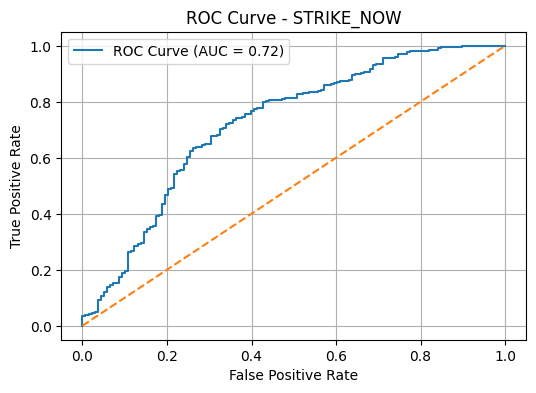

In [66]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

y_probs = model_now.predict_proba(X_now_val)[:, 1]
fpr, tpr, _ = roc_curve(y_now_val, y_probs)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 4))
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - STRIKE_NOW')
plt.legend()
plt.grid(True)
plt.show()


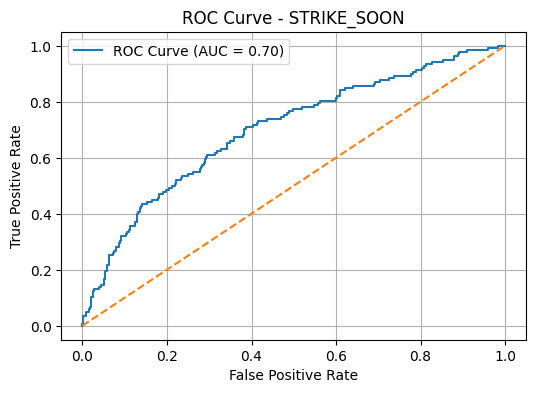

In [67]:
from sklearn.metrics import roc_curve, auc

y_probs_soon = model_soon.predict_proba(X_soon_val)[:, 1]
fpr_soon, tpr_soon, _ = roc_curve(y_soon_val, y_probs_soon)
roc_auc_soon = auc(fpr_soon, tpr_soon)

plt.figure(figsize=(6, 4))
plt.plot(fpr_soon, tpr_soon, label=f'ROC Curve (AUC = {roc_auc_soon:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - STRIKE_SOON')
plt.legend()
plt.grid(True)
plt.show()


In [68]:
from sklearn.model_selection import StratifiedKFold, permutation_test_score

# For model_now
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_now, perm_scores_now, pvalue_now = permutation_test_score(
    model_now, X_now_val.to_numpy(), y_now_val.to_numpy(),
    scoring="accuracy", cv=cv, n_permutations=100, random_state=42
)
print(f"[STRIKE_NOW] Accuracy: {score_now:.4f}, p-value: {pvalue_now:.4f}")

# For model_soon
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
score_soon, perm_scores_soon, pvalue_soon = permutation_test_score(
    model_soon, X_soon_val.to_numpy(), y_soon_val.to_numpy(),
    scoring="accuracy", cv=cv, n_permutations=100, random_state=42
)
print(f"[STRIKE_SOON] Accuracy: {score_soon:.4f}, p-value: {pvalue_soon:.4f}")


[STRIKE_NOW] Accuracy: 0.7694, p-value: 0.0099
[STRIKE_SOON] Accuracy: 0.7559, p-value: 0.0990


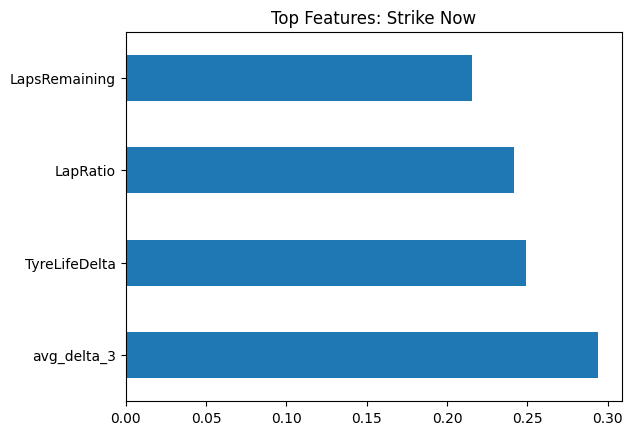

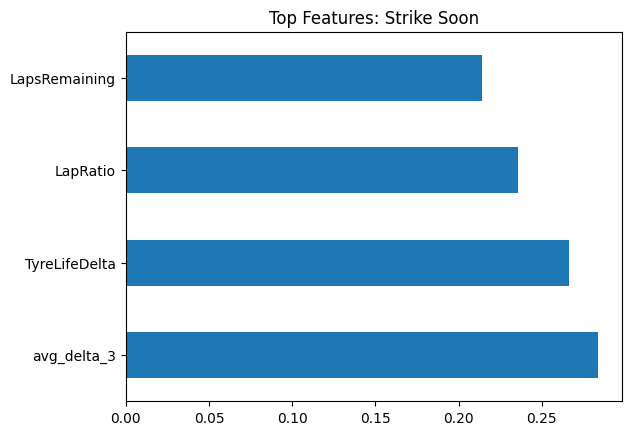

In [69]:
import pandas as pd
import matplotlib.pyplot as plt

# Strike Now Feature Importance
imp_now = pd.Series(model_now.feature_importances_, index=X_test_classification.columns)
imp_now.nlargest(10).plot(kind='barh', title='Top Features: Strike Now')
plt.show()

# Strike Soon Feature Importance
imp_soon = pd.Series(model_soon.feature_importances_, index=X_test_classification.columns)
imp_soon.nlargest(10).plot(kind='barh', title='Top Features: Strike Soon')
plt.show()


In [70]:
!pip install shap

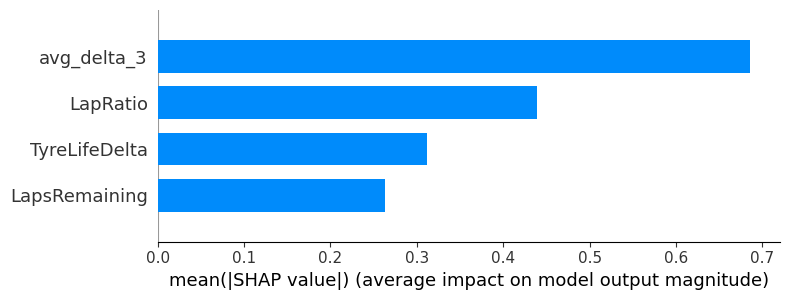

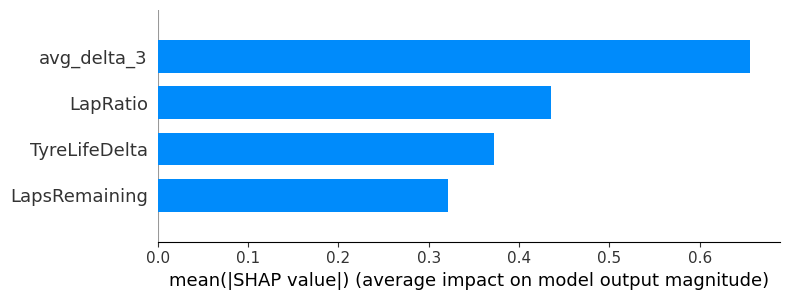

In [71]:
import shap

# Initialize SHAP explainer for STRIKE_NOW model
explainer_now = shap.Explainer(model_now)
shap_values_now = explainer_now(X_now_val)

# Plot summary for STRIKE_NOW
shap.summary_plot(shap_values_now, X_now_val, plot_type="bar", show=True)

# Initialize SHAP explainer for STRIKE_SOON model
explainer_soon = shap.Explainer(model_soon)
shap_values_soon = explainer_soon(X_soon_val)

# Plot summary for STRIKE_SOON
shap.summary_plot(shap_values_soon, X_soon_val, plot_type="bar", show=True)


In [72]:
from sklearn.metrics import classification_report

# Apply trained model_now to 2025 test set
y_pred_now_test = model_now.predict(X_test_classification)
print("STRIKE_NOW Test Set Results:")
print(classification_report(y_test_now, y_pred_now_test))

# Apply trained model_soon to 2025 test set
y_pred_soon_test = model_soon.predict(X_test_classification)
print("STRIKE_SOON Test Set Results:")
print(classification_report(y_test_soon, y_pred_soon_test))


STRIKE_NOW Test Set Results:
              precision    recall  f1-score   support

           0       0.38      0.14      0.20        22
           1       0.91      0.97      0.94       198

    accuracy                           0.89       220
   macro avg       0.64      0.56      0.57       220
weighted avg       0.86      0.89      0.87       220

STRIKE_SOON Test Set Results:
              precision    recall  f1-score   support

           0       0.91      0.97      0.94       198
           1       0.38      0.14      0.20        22

    accuracy                           0.89       220
   macro avg       0.64      0.56      0.57       220
weighted avg       0.86      0.89      0.87       220



--------------------------------------------------------------------------------

## Regression

In [332]:
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Train-test split for regression
X_train_reg, X_val_reg, y_train_reg, y_val_reg = train_test_split(
    X_reg, y_reg, test_size=0.2, random_state=42
)


In [353]:

reg_model = XGBRegressor(
    n_estimators=600,
    learning_rate=0.004,
    max_depth=4,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    reg_alpha=0.5,
    reg_lambda=1.0,
    # tree_method='hist'
)
reg_model.fit(X_train_reg, y_train_reg)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.004, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=4, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=600, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [405]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_val_pred = reg_model.predict(X_val_reg)

mae = mean_absolute_error(y_val_reg, y_val_pred)
rmse = mean_squared_error(y_val_reg, y_val_pred) ** 0.5
r2 = r2_score(y_val_reg, y_val_pred)
print("Validation Results:")
print(f"MAE: {mae:.2f}")
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")


Validation Results:
MAE: 0.33
RMSE: 1.01
R²: 0.56


In [359]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# # Predict on 2025 test data
# y_test_pred = reg_model.predict(X_test)

# Predict on 2025 test data
y_test_pred = reg_model.predict(X_test_regression)

# Optional: clip predictions to expected range [0, 15]
y_test_pred_clipped = y_test_pred.clip(0, 15)

# Round to nearest integer (you'll use this for display or interpretation)
y_test_pred_rounded = y_test_pred_clipped.round().astype(int)

# Optional: print side-by-side for inspection
pd.DataFrame({
    "Actual": y_test_reg,
    "Predicted (raw)": y_test_pred,
    "Predicted (rounded)": y_test_pred_rounded
}).head(5)


,Actual,Predicted (raw),Predicted (rounded)
28,0,0.038710,0
9,0,0.059464,0
10,0,0.057493,0
11,0,0.053302,0
12,0,0.030677,0


In [406]:

# Evaluate
mae_test = mean_absolute_error(y_test_reg, y_test_pred)
rmse_test = mean_squared_error(y_test_reg, y_test_pred) ** 0.5
r2_test = r2_score(y_test_reg, y_test_pred)
print("Test Results:")
print(f"Test MAE: {mae_test:.2f}")
print(f"Test RMSE: {rmse_test:.2f}")
print(f"Test R²: {r2_test:.2f}")

Test Results:
Test MAE: 0.14
Test RMSE: 0.41
Test R²: 0.54


## SHAP and Visual Prediction

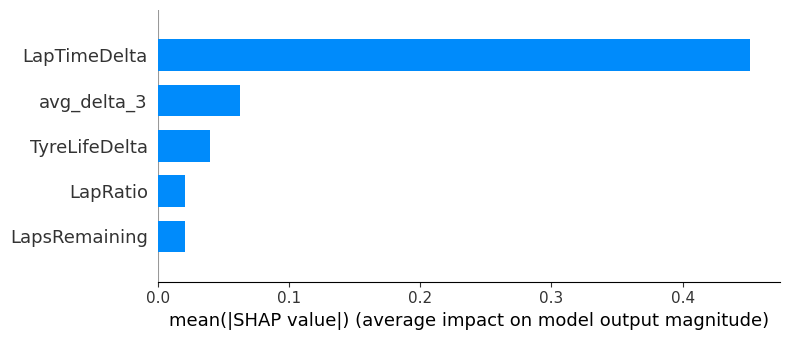

In [363]:
# ===== Test Set SHAP Analysis (2025) =====
shap_values_test = explainer(X_test_regression)

# Summary Plot (Test)
shap.summary_plot(shap_values_test, X_test_regression, plot_type="bar", show=True)
# shap.summary_plot(shap_values_test, X_test, show=True)


In [364]:
# Scatterplot using rounded predictions
df_plot = pd.DataFrame({
    'Actual': y_test_reg,
    'Predicted': y_test_pred_rounded
})

fig = px.scatter(
    df_plot,
    x='Actual',
    y='Predicted',
    color='Actual',
    color_continuous_scale='Viridis',
    title='Rounded Predicted vs Actual Laps to Strike (2025)',
    labels={'Actual': 'Actual Laps to Strike', 'Predicted': 'Rounded Prediction'},
    opacity=0.7,
    height=600,
    width=900
)

# Add diagonal perfect-prediction line
fig.add_shape(
    type='line',
    x0=df_plot['Actual'].min(), y0=df_plot['Actual'].min(),
    x1=df_plot['Actual'].max(), y1=df_plot['Actual'].max(),
    line=dict(color='red', dash='dash')
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=22),
    xaxis_title='Actual Laps to Strike',
    yaxis_title='Predicted Laps to Strike (Rounded)'
)

fig.show()


In [366]:
# STEP 1: Extract features
X_test_reg = test_p1_p2_df[base_features_regression].copy()

# STEP 2: Predict laps_to_strike
y_test_pred = reg_model.predict(X_test_reg)

# STEP 3: Attach predictions
test_p1_p2_df["Predicted_LapsToStrike"] = y_test_pred.clip(0, 15).round().astype(int)

# STEP 4: Build leaderboard-like summary
summary_df = test_p1_p2_df[[
    'Year', 'Round', 'RaceName', 'LapNumber',
    'Leader', 'Chaser', 'Predicted_LapsToStrike'
]].sort_values(by='Predicted_LapsToStrike')

In [367]:
import plotly.express as px

# STEP 1: Apply model to test set
# X_test_reg = test_p1_p2_df[base_features].copy()
y_test_pred = reg_model.predict(X_test_reg)

# STEP 2: Attach rounded predictions to test data
test_p1_p2_df['Predicted_LapsToStrike'] = y_test_pred.clip(0, 15).round().astype(int)

# STEP 3: Build leaderboard-style summary
summary_df = test_p1_p2_df[[
    'Year', 'Round', 'RaceName', 'LapNumber',
    'Leader', 'Chaser', 'Predicted_LapsToStrike'
]].sort_values(by='Predicted_LapsToStrike')

# STEP 4: Create Plotly Table
fig = px.scatter(
    summary_df,
    x='LapNumber',
    y='Predicted_LapsToStrike',
    color='Chaser',
    hover_data=['RaceName', 'Leader', 'Chaser'],
    title='Predicted Laps to Strike between Leader and Chaser (2025)',
    labels={
        'LapNumber': 'Lap Number',
        'Predicted_LapsToStrike': 'Predicted Laps to Strike'
    },
    height=500
)

fig.update_layout(template='plotly_white')
fig.show()

In [368]:
import plotly.express as px

# X_test_reg = test_p1_p2_df[base_features].copy()
y_test_pred = reg_model.predict(X_test_reg)

# Adding predictions (rounded 0–15) to the test dataframe
test_p1_p2_df['Predicted_LapsToStrike'] = y_test_pred.clip(0, 15).round().astype(int)

summary_df = test_p1_p2_df[[
    'Year', 'Round', 'RaceName', 'LapNumber',
    'Leader', 'Chaser', 'Predicted_LapsToStrike'
]].copy()

summary_df = summary_df.sort_values(by=['Year', 'Round', 'LapNumber'])

fig = px.scatter(
    summary_df,
    x='LapNumber',
    y='Predicted_LapsToStrike',
    color='Chaser',
    facet_col='RaceName',
    facet_col_wrap=3,
    hover_data=['Leader', 'Chaser'],
    title='Race-wise Predicted Laps to Strike (Leader vs Chaser)',
    labels={
        'LapNumber': 'Lap Number',
        'Predicted_LapsToStrike': 'Predicted Laps to Strike'
    },
    height=600
)

fig.update_layout(
    template='plotly_white',
    title_font=dict(size=20),
    font=dict(size=12),
    margin=dict(t=80)
)
fig.show()


# Prediction 2: Predicting Overtake Likelihood of Chaser to Leader


## Data Extraction:
This function gets the detailed speed, throttle, and brake data for a specific lap from the FastF1 API, for both the leader and the chaser. It packages this information into a single dictionary so it can be saved later.

There is no need to run the cells fetching data from FastF1 API, instead just  run the cells which are extracting data from csv files. After fetching data from API, I have stored it in csv files. I have given the access of the required csv files. Moreover, I have attached csv in the submitted github repo.

In [369]:
def extract_telemetry_features_for_pair(year, gp_round, lap_number, leader, chaser):
    try:
        # Load session
        session = fastf1.get_session(year, gp_round, 'R')
        session.load()

        # Helper to extract telemetry safely
        def get_driver_features(driver):
            lap = session.laps[
                (session.laps['Driver'] == driver) &
                (session.laps['LapNumber'] == lap_number)
            ]
            if lap.empty:
                return None

            telemetry = lap.iloc[0].get_telemetry()
            return {
                "SpeedFL": telemetry['Speed'].mean(),
                "ThrottleAvg": telemetry['Throttle'].mean(),
                "BrakeAvg": telemetry['Brake'].astype(float).mean()
            }

        # Extract features for both
        chaser_feats = get_driver_features(chaser)
        leader_feats = get_driver_features(leader)

        # If either telemetry is missing, skip this row
        if chaser_feats is None or leader_feats is None:
            return None

        # Combine all in a dict
        result = {
            "Year": year,
            "Round": gp_round,
            "LapNumber": lap_number,
            "Leader": leader,
            "Chaser": chaser
        }

        # Prefix and merge
        result.update({f"Chaser_{k}": v for k, v in chaser_feats.items()})
        result.update({f"Leader_{k}": v for k, v in leader_feats.items()})

        return result

    except Exception as e:
        print(f"Failed for {year} R{gp_round} Lap {lap_number} {chaser} chasing {leader}: {e}")
        return None

Below code is to test whether data is getting fetched from API

In [ ]:
# row = test_p1_p2_df.iloc[0]
# features = extract_telemetry_features_for_pair(
#     year=row['Year'],
#     gp_round=row['Round'],
#     lap_number=row['LapNumber'],
#     leader=row['Leader'],
#     chaser=row['Chaser']
# )
# print(features)


core           INFO 	Loading data for Australian Grand Prix - Race [v3.5.3]
INFO:fastf1.fastf1.core:Loading data for Australian Grand Prix - Race [v3.5.3]
req            INFO 	Using cached data for session_info
INFO:fastf1.fastf1.req:Using cached data for session_info
req            INFO 	Using cached data for driver_info
INFO:fastf1.fastf1.req:Using cached data for driver_info
req            INFO 	Using cached data for session_status_data
INFO:fastf1.fastf1.req:Using cached data for session_status_data
req            INFO 	Using cached data for lap_count
INFO:fastf1.fastf1.req:Using cached data for lap_count
req            INFO 	Using cached data for track_status_data
INFO:fastf1.fastf1.req:Using cached data for track_status_data
req            INFO 	Using cached data for _extended_timing_data
INFO:fastf1.fastf1.req:Using cached data for _extended_timing_data
req            INFO 	Using cached data for timing_app_data
INFO:fastf1.fastf1.req:Using cached data for timing_app_data
core   

{'Year': np.int64(2025), 'Round': np.int64(1), 'LapNumber': np.float64(46.0), 'Leader': 'HAM', 'Chaser': 'LEC', 'Chaser_SpeedFL': np.float64(194.16005831950946), 'Chaser_ThrottleAvg': np.float64(57.804877911836925), 'Chaser_BrakeAvg': np.float64(0.32825484764542934), 'Leader_SpeedFL': np.float64(195.68153756993587), 'Leader_ThrottleAvg': np.float64(62.82350374469288), 'Leader_BrakeAvg': np.float64(0.2644628099173554)}


This below function goes through each race lap in your DataFrame, fetches car performance data (like speed, throttle, and brake) for the leader and chaser, and saves it to a CSV file. If it gets interrupted, it can resume from where it stopped.

process_telemetry_for_df is the controller — it loops over every lap, calls the extract_telemetry_features_for_pair, and saves it.

extract_telemetry_features_for_pair is the worker — it fetches the actual telemetry data for each lap

In [ ]:
import pandas as pd
import time
import os

def process_telemetry_for_df(df, output_csv='telemetry_features.csv', delay_sec=7):
    # Load existing processed data
    if os.path.exists(output_csv):
        done_df = pd.read_csv(output_csv)
        done_keys = set(tuple(row) for row in done_df[['Year', 'Round', 'LapNumber', 'Leader', 'Chaser']].values)
        print(f"Loaded {len(done_df)} previously completed rows.")
    else:
        done_df = pd.DataFrame()
        done_keys = set()
        print("🔁 Starting fresh telemetry processing.")

    results = []
    api_hits = 0

    for idx, row in df.iterrows():
        key = (row['Year'], row['Round'], row['LapNumber'], row['Leader'], row['Chaser'])

        if key in done_keys:
            continue  # Already processed

        print(f"Processing: {key}")
        features = extract_telemetry_features_for_pair(*key)

        if features:
            results.append(features)
            api_hits += 2  # 2 drivers = 2 telemetry calls

        # Save progress every 25 rows or if hit limit
        if len(results) >= 25 or api_hits >= 490:
            new_df = pd.DataFrame(results)
            new_df.to_csv(output_csv, mode='a', header=not os.path.exists(output_csv), index=False)
            print(f"Saved {len(results)} new rows.")
            results = []
            done_keys.update((row['Year'], row['Round'], row['LapNumber'], row['Leader'], row['Chaser']) for _, row in new_df.iterrows())

        if api_hits >= 490:
            print("API hit limit approached. Please resume in 1 hour.")
            break

        time.sleep(delay_sec)

    # Final save if anything remains
    if results:
        new_df = pd.DataFrame(results)
        new_df.to_csv(output_csv, mode='a', header=not os.path.exists(output_csv), index=False)
        print(f"Final save of {len(results)} rows.")

    print("Processing complete (or paused).")


In [ ]:

# For testing data (save separately)
process_telemetry_for_df(test_p1_p2_df, output_csv='test_telemetry_features.csv')


In [ ]:
# For training data
process_telemetry_for_df(p1_p2_df, output_csv='telemetry_features.csv')


In [370]:
telemetry_path = 'telemetry_features.csv'

# Read the CSV into a DataFrame
telemetry_df = pd.read_csv(telemetry_path)

# Preview the first few rows
print(telemetry_df.shape)
telemetry_df.head()

(3357, 11)


,Year,Round,LapNumber,Leader,Chaser,Chaser_SpeedFL,Chaser_ThrottleAvg,Chaser_BrakeAvg,Leader_SpeedFL,Leader_ThrottleAvg,Leader_BrakeAvg
0,2022,1,31.0,LEC,SAI,195.042780,65.887151,0.205369,189.272627,65.366171,0.232376
1,2022,1,44.0,LEC,SAI,192.297278,65.316325,0.219287,198.627869,69.206929,0.213514
2,2022,1,54.0,LEC,SAI,200.609106,67.134007,0.211829,203.666072,71.037178,0.194175
3,2022,1,55.0,LEC,SAI,201.353668,69.614598,0.182186,202.067483,69.978426,0.193989
4,2022,1,56.0,LEC,SAI,201.295509,68.862736,0.182192,200.391428,70.572522,0.184426


In [371]:
telemetry_path = 'test_telemetry_features.csv'

# Read the CSV into a DataFrame
test_telemetry_df = pd.read_csv(telemetry_path)

# Preview the first few rows
print(test_telemetry_df.shape)
test_telemetry_df.head()

(220, 11)


,Year,Round,LapNumber,Leader,Chaser,Chaser_SpeedFL,Chaser_ThrottleAvg,Chaser_BrakeAvg,Leader_SpeedFL,Leader_ThrottleAvg,Leader_BrakeAvg
0,2025,1,46.0,HAM,LEC,194.160058,57.804878,0.328255,195.681538,62.823504,0.264463
1,2025,1,17.0,NOR,PIA,206.132286,62.740673,0.190612,208.649933,64.162536,0.152639
2,2025,1,18.0,NOR,PIA,209.786291,65.277671,0.174699,208.926978,63.675203,0.166163
3,2025,1,19.0,NOR,PIA,208.805633,64.672043,0.166423,209.363774,64.795427,0.167883
4,2025,1,20.0,NOR,PIA,210.372359,64.784145,0.182353,207.064134,63.378491,0.169839


## Data Merging:

This function takes your main race data and the telemetry data from CSV, and it joins (merges) them together based on matching values like year, round, lap, leader, and chaser. It adds all the telemetry features into your main DataFrame.

In [372]:
def merge_telemetry_to_p1p2(main_df, telemetry_csv):

    telemetry_df = pd.read_csv(telemetry_csv)

    merged_df = main_df.merge(
        telemetry_df,
        on=['Year', 'Round', 'LapNumber', 'Leader', 'Chaser'],
        how='left'
    )

    print(f"Merge complete: {merged_df.shape[0]} rows, {merged_df.shape[1]} columns.")
    return merged_df


In [373]:
p1_p2_df = merge_telemetry_to_p1p2(p1_p2_df, 'telemetry_features.csv')


✅ Merge complete: 3357 rows, 33 columns.


In [374]:
test_p1_p2_df = merge_telemetry_to_p1p2(test_p1_p2_df, 'test_telemetry_features.csv')


✅ Merge complete: 220 rows, 34 columns.


## Data Augmentation:

This code calculates the difference (delta) between the chaser's and leader's values for speed, throttle, and braking. It does this for both the training data (p1_p2_df) and the testing data (test_p1_p2_df).

In [375]:
# Compute delta columns for training data
p1_p2_df['Delta_SpeedFL'] = p1_p2_df['Chaser_SpeedFL'] - p1_p2_df['Leader_SpeedFL']
p1_p2_df['Delta_ThrottleAvg'] = p1_p2_df['Chaser_ThrottleAvg'] - p1_p2_df['Leader_ThrottleAvg']
p1_p2_df['Delta_BrakeAvg'] = p1_p2_df['Chaser_BrakeAvg'] - p1_p2_df['Leader_BrakeAvg']

# Compute delta columns for testing data
test_p1_p2_df['Delta_SpeedFL'] = test_p1_p2_df['Chaser_SpeedFL'] - test_p1_p2_df['Leader_SpeedFL']
test_p1_p2_df['Delta_ThrottleAvg'] = test_p1_p2_df['Chaser_ThrottleAvg'] - test_p1_p2_df['Leader_ThrottleAvg']
test_p1_p2_df['Delta_BrakeAvg'] = test_p1_p2_df['Chaser_BrakeAvg'] - test_p1_p2_df['Leader_BrakeAvg']


In [376]:
p1_p2_df.columns

Index(['Year', 'Round', 'RaceName', 'LapNumber', 'Leader', 'Chaser', 'gap',
       'LeaderLapTime', 'ChaserLapTime', 'LapTimeDelta', 'LeaderTyreLife',
       'ChaserTyreLife', 'TyreLifeDelta', 'LeaderCompound', 'ChaserCompound',
       'avg_delta_3', 'LapTime', 'TyreLife', 'LapsRemaining', 'LapRatio',
       'LeaderCompoundEncoded', 'ChaserCompoundEncoded', 'laps_to_strike',
       'LeaderNumber', 'ChaserNumber', 'strike_now', 'strike_soon',
       'Chaser_SpeedFL', 'Chaser_ThrottleAvg', 'Chaser_BrakeAvg',
       'Leader_SpeedFL', 'Leader_ThrottleAvg', 'Leader_BrakeAvg',
       'Delta_SpeedFL', 'Delta_ThrottleAvg', 'Delta_BrakeAvg'],
      dtype='object')

In [377]:
p1_p2_df.rename(columns={
    'gap': 'Gap',
    'avg_delta_3': 'AvgDelta3',
    'laps_to_strike': 'LapsToStrike',
    'strike_now': 'StrikeNow',
    'strike_soon': 'StrikeSoon',
    'Chaser_SpeedFL': 'ChaserSpeedFL',
    'Chaser_ThrottleAvg': 'ChaserThrottleAvg',
    'Chaser_BrakeAvg': 'ChaserBrakeAvg',
    'Leader_SpeedFL': 'LeaderSpeedFL',
    'Leader_ThrottleAvg': 'LeaderThrottleAvg',
    'Leader_BrakeAvg': 'LeaderBrakeAvg',
    'Delta_SpeedFL': 'SpeedFLDelta',
    'Delta_ThrottleAvg': 'ThrottleAvgDelta',
    'Delta_BrakeAvg': 'BrakeAvgDelta'
}, inplace=True)


In [378]:
test_p1_p2_df.rename(columns={
    'gap': 'Gap',
    'avg_delta_3': 'AvgDelta3',
    'laps_to_strike': 'LapsToStrike',
    'strike_now': 'StrikeNow',
    'strike_soon': 'StrikeSoon',
    'Chaser_SpeedFL': 'ChaserSpeedFL',
    'Chaser_ThrottleAvg': 'ChaserThrottleAvg',
    'Chaser_BrakeAvg': 'ChaserBrakeAvg',
    'Leader_SpeedFL': 'LeaderSpeedFL',
    'Leader_ThrottleAvg': 'LeaderThrottleAvg',
    'Leader_BrakeAvg': 'LeaderBrakeAvg',
    'Delta_SpeedFL': 'SpeedFLDelta',
    'Delta_ThrottleAvg': 'ThrottleAvgDelta',
    'Delta_BrakeAvg': 'BrakeAvgDelta'
}, inplace=True)


In [379]:
p1_p2_df.head()

,Year,Round,RaceName,LapNumber,Leader,Chaser,Gap,LeaderLapTime,ChaserLapTime,LapTimeDelta,...,StrikeSoon,ChaserSpeedFL,ChaserThrottleAvg,ChaserBrakeAvg,LeaderSpeedFL,LeaderThrottleAvg,LeaderBrakeAvg,SpeedFLDelta,ThrottleAvgDelta,BrakeAvgDelta
0,2022,1,Bahrain Grand Prix,31.0,LEC,SAI,-2.440,101.545,99.105,2.440,...,0,195.042780,65.887151,0.205369,189.272627,65.366171,0.232376,5.770153,0.520979,-0.027007
1,2022,1,Bahrain Grand Prix,44.0,LEC,SAI,2.190,97.509,99.699,-2.190,...,1,192.297278,65.316325,0.219287,198.627869,69.206929,0.213514,-6.330591,-3.890604,0.005773
2,2022,1,Bahrain Grand Prix,54.0,LEC,SAI,1.136,95.429,96.565,-1.136,...,1,200.609106,67.134007,0.211829,203.666072,71.037178,0.194175,-3.056966,-3.903171,0.017655
3,2022,1,Bahrain Grand Prix,55.0,LEC,SAI,0.648,95.427,96.075,-0.648,...,1,201.353668,69.614598,0.182186,202.067483,69.978426,0.193989,-0.713815,-0.363828,-0.011803
4,2022,1,Bahrain Grand Prix,56.0,LEC,SAI,0.094,95.673,95.767,-0.094,...,0,201.295509,68.862736,0.182192,200.391428,70.572522,0.184426,0.904081,-1.709786,-0.002234


In [380]:
p1_p2_df.shape

(3357, 36)

## Data Cleaning:

In [382]:
# Define columns to check for missing values
columns_to_check = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'Gap', 'LapTimeDelta', 'TyreLifeDelta'
]

# Count missing values
print("Missing value summary:")
print(p1_p2_df[columns_to_check].isnull().sum())

# Drop rows with any missing values in key columns
p1_p2_df_cleaned = p1_p2_df.dropna(subset=columns_to_check).copy()

print(f"Cleaned shape: {p1_p2_df_cleaned.shape}")


Missing value summary:
SpeedFLDelta        0
ThrottleAvgDelta    0
BrakeAvgDelta       0
Gap                 0
LapTimeDelta        0
TyreLifeDelta       0
dtype: int64
Cleaned shape: (3357, 36)


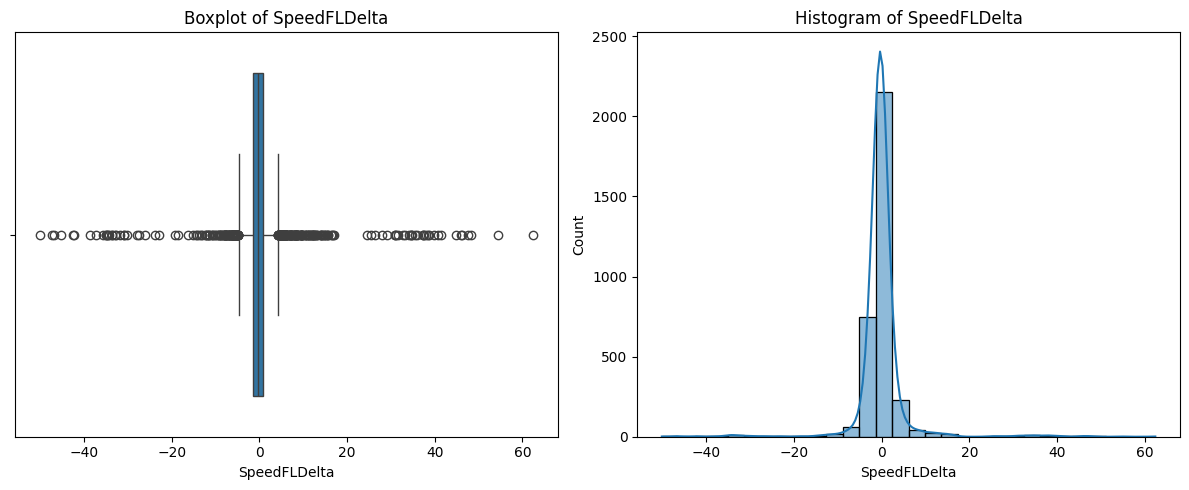

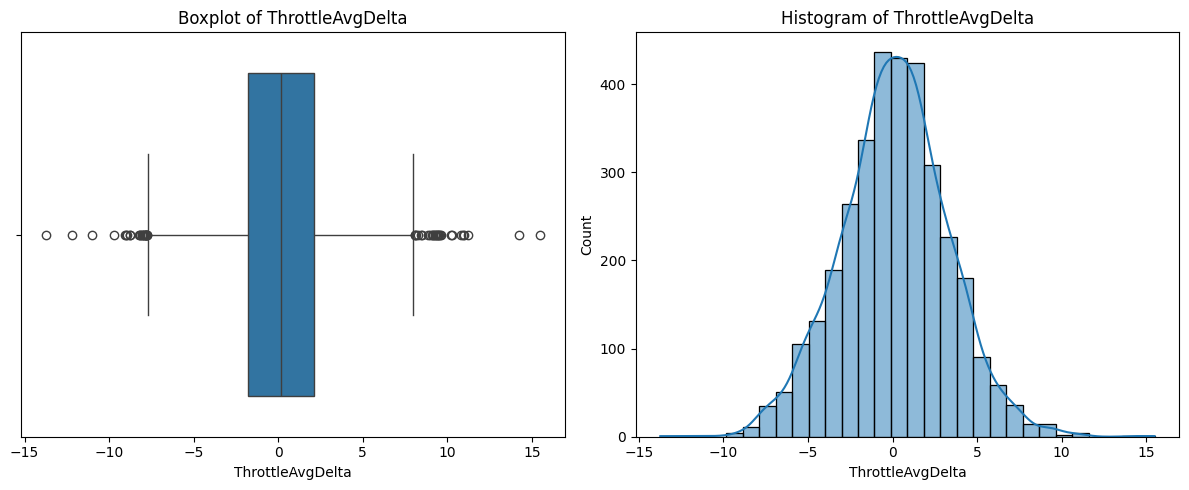

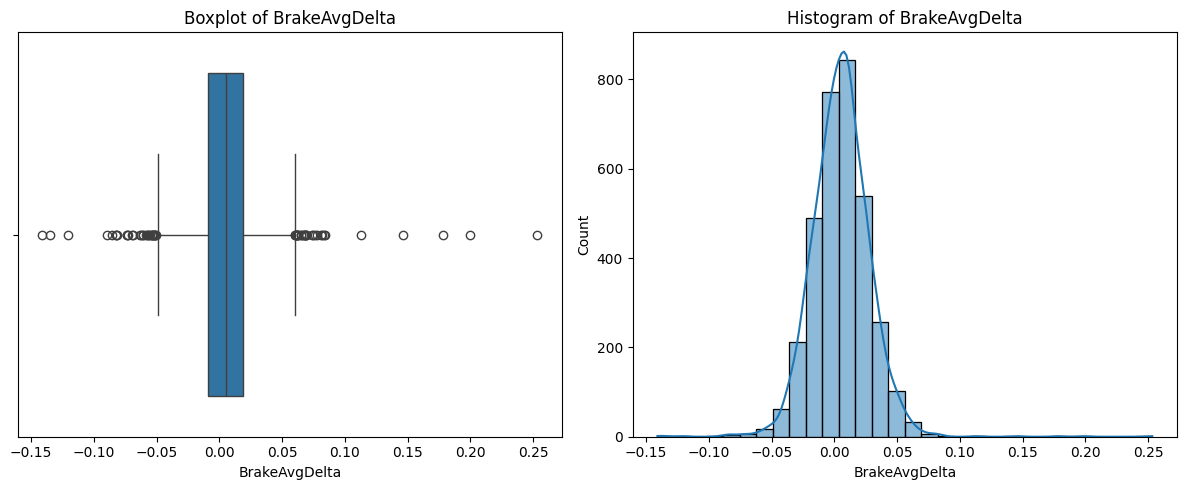

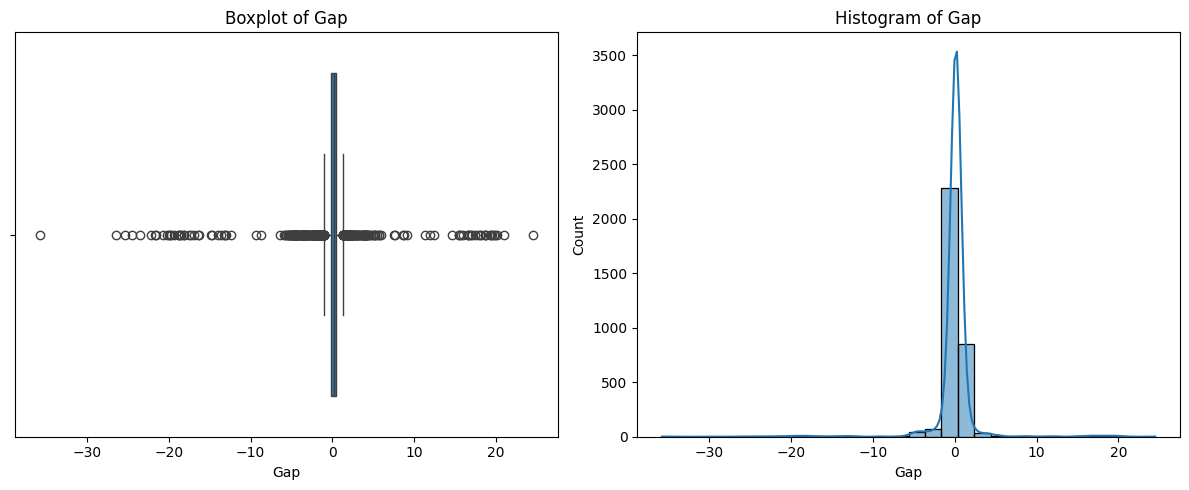

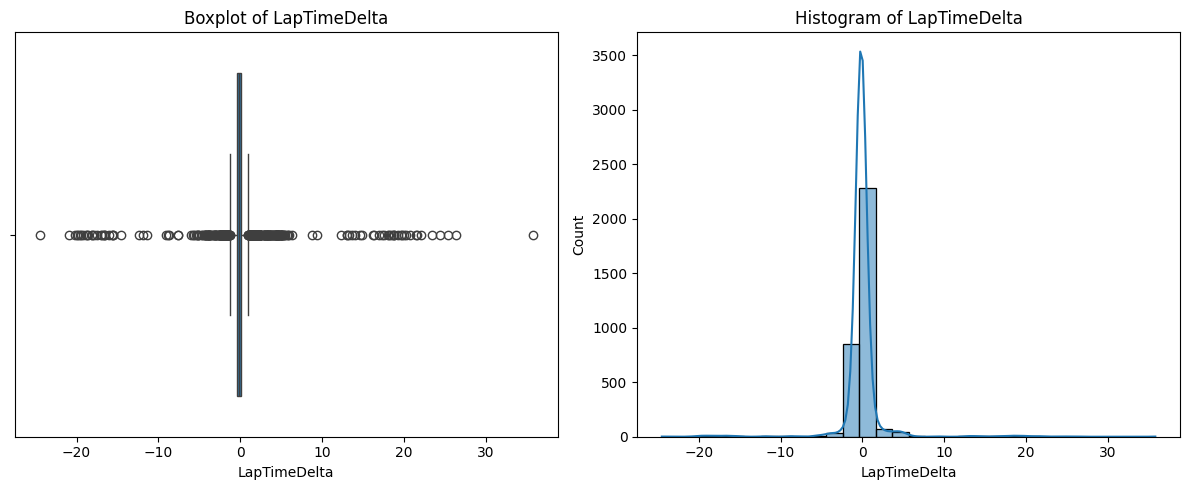

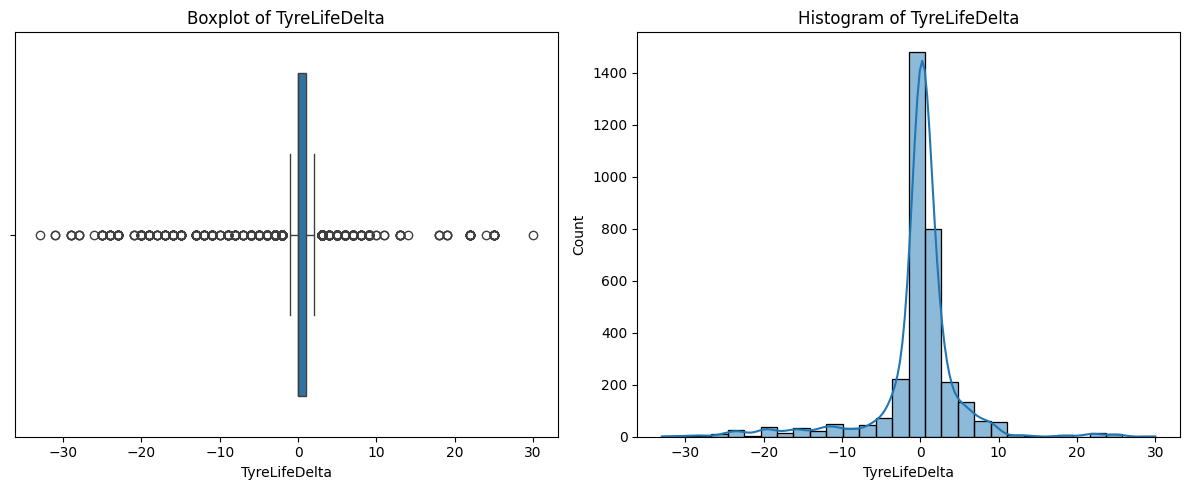

In [383]:
import matplotlib.pyplot as plt
import seaborn as sns

# Columns you want to check
columns_to_plot = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'Gap', 'LapTimeDelta', 'TyreLifeDelta'
]

# Plotting
for col in columns_to_plot:
    plt.figure(figsize=(12, 5))

    # Boxplot
    plt.subplot(1, 2, 1)
    sns.boxplot(x=p1_p2_df[col])
    plt.title(f'Boxplot of {col}')

    # Histogram
    plt.subplot(1, 2, 2)
    sns.histplot(p1_p2_df[col], kde=True, bins=30)
    plt.title(f'Histogram of {col}')

    plt.tight_layout()
    plt.show()


In [384]:
def clip_outliers_iqr(df, columns, clip_multiplier=1.5):
    df_clipped = df.copy()
    for col in columns:
        Q1 = df_clipped[col].quantile(0.25)
        Q3 = df_clipped[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - clip_multiplier * IQR
        upper = Q3 + clip_multiplier * IQR

        before_min = df_clipped[col].min()
        before_max = df_clipped[col].max()

        df_clipped[col] = df_clipped[col].clip(lower, upper)

        after_min = df_clipped[col].min()
        after_max = df_clipped[col].max()

        print(f"Clipped {col}: from ({before_min:.2f}, {before_max:.2f}) to ({after_min:.2f}, {after_max:.2f})")

    return df_clipped


In [385]:
columns_to_clip = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'Gap', 'LapTimeDelta', 'TyreLifeDelta'
]

p1_p2_df = clip_outliers_iqr(p1_p2_df, columns_to_clip)


Clipped SpeedFLDelta: from (-50.19, 62.43) to (-4.79, 4.21)
Clipped ThrottleAvgDelta: from (-13.74, 15.50) to (-7.75, 8.07)
Clipped BrakeAvgDelta: from (-0.14, 0.25) to (-0.05, 0.06)
Clipped Gap: from (-35.79, 24.52) to (-0.99, 1.29)
Clipped LapTimeDelta: from (-24.52, 35.79) to (-1.29, 0.99)
Clipped TyreLifeDelta: from (-33.00, 30.00) to (-1.50, 2.50)


In [388]:
def remove_iqr_outliers(df, columns):
    cleaned_df = df.copy()
    for col in columns:
        Q1 = cleaned_df[col].quantile(0.25)
        Q3 = cleaned_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower = Q1 - 2 * IQR
        upper = Q3 + 2 * IQR
        before = cleaned_df.shape[0]
        cleaned_df = cleaned_df[(cleaned_df[col] >= lower) & (cleaned_df[col] <= upper)]
        after = cleaned_df.shape[0]
        print(f"{col}: Removed {before - after} outliers")
    return cleaned_df

# Columns to evaluate for outliers
outlier_columns = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'Gap', 'LapTimeDelta', 'TyreLifeDelta'
]

# Apply outlier cleaning
p1_p2_df_cleaned = remove_iqr_outliers(p1_p2_df_cleaned, outlier_columns)

print(f"Final cleaned shape: {p1_p2_df_cleaned.shape}")


SpeedFLDelta: Removed 7 outliers
ThrottleAvgDelta: Removed 0 outliers
BrakeAvgDelta: Removed 0 outliers
Gap: Removed 4 outliers
LapTimeDelta: Removed 0 outliers
TyreLifeDelta: Removed 0 outliers
Final cleaned shape: (2328, 36)


## EDA

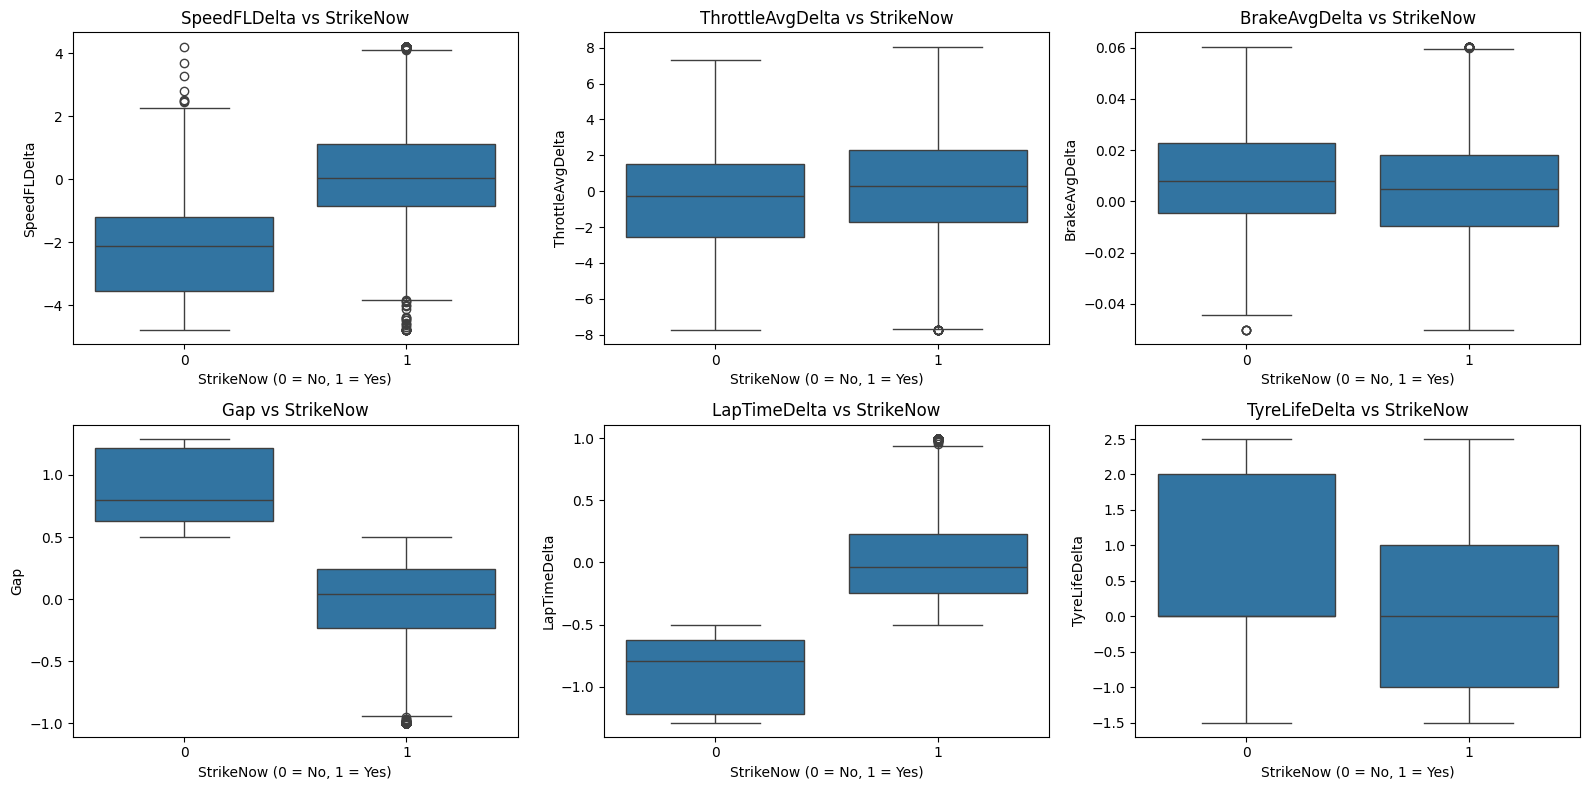

In [389]:
import seaborn as sns
import matplotlib.pyplot as plt

# Key features to compare
features = ['SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta', 'Gap', 'LapTimeDelta', 'TyreLifeDelta']

# Set up grid
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16, 8))
axes = axes.flatten()

# Plot each feature
for i, col in enumerate(features):
    sns.boxplot(x='StrikeNow', y=col, data=p1_p2_df, ax=axes[i])
    axes[i].set_title(f'{col} vs StrikeNow')
    axes[i].set_xlabel('StrikeNow (0 = No, 1 = Yes)')
    axes[i].set_ylabel(col)

plt.tight_layout()
plt.show()


In [390]:
import plotly.express as px
import pandas as pd

# Subset for correlation
features_for_corr = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'Gap', 'LapTimeDelta', 'TyreLifeDelta',
    'LapRatio', 'LapsRemaining'
]

# Compute correlation matrix
corr_matrix = p1_p2_df[features_for_corr].corr().round(2)

# Plot with Plotly
fig = px.imshow(
    corr_matrix,
    text_auto=True,
    color_continuous_scale='RdBu_r',
    title='Feature Correlation Matrix (Interactive)',
    aspect='auto',
    width=800,
    height=600
)

fig.update_layout(
    font=dict(size=14),
    title_font=dict(size=22),
    margin=dict(t=60, l=40, r=40, b=40)
)

fig.show()


In [391]:
p1_p2_df.drop(columns=['LapsRemaining'], inplace=True)


In [392]:
test_p1_p2_df.drop(columns=['LapsRemaining'], inplace=True)

In [393]:
p1_p2_df.columns

Index(['Year', 'Round', 'RaceName', 'LapNumber', 'Leader', 'Chaser', 'Gap',
       'LeaderLapTime', 'ChaserLapTime', 'LapTimeDelta', 'LeaderTyreLife',
       'ChaserTyreLife', 'TyreLifeDelta', 'LeaderCompound', 'ChaserCompound',
       'AvgDelta3', 'LapTime', 'TyreLife', 'LapRatio', 'LeaderCompoundEncoded',
       'ChaserCompoundEncoded', 'LapsToStrike', 'LeaderNumber', 'ChaserNumber',
       'StrikeNow', 'StrikeSoon', 'ChaserSpeedFL', 'ChaserThrottleAvg',
       'ChaserBrakeAvg', 'LeaderSpeedFL', 'LeaderThrottleAvg',
       'LeaderBrakeAvg', 'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta'],
      dtype='object')

In [394]:
test_p1_p2_df.columns

Index(['Year', 'Round', 'RaceName', 'LapNumber', 'Leader', 'Chaser', 'Gap',
       'LeaderLapTime', 'ChaserLapTime', 'LapTimeDelta', 'LeaderTyreLife',
       'ChaserTyreLife', 'TyreLifeDelta', 'LeaderCompound', 'ChaserCompound',
       'AvgDelta3', 'LapTime', 'TyreLife', 'LapRatio', 'LeaderCompoundEncoded',
       'ChaserCompoundEncoded', 'LapsToStrike', 'LeaderNumber', 'ChaserNumber',
       'StrikeNow', 'StrikeSoon', 'Predicted_LapsToStrike', 'ChaserSpeedFL',
       'ChaserThrottleAvg', 'ChaserBrakeAvg', 'LeaderSpeedFL',
       'LeaderThrottleAvg', 'LeaderBrakeAvg', 'SpeedFLDelta',
       'ThrottleAvgDelta', 'BrakeAvgDelta'],
      dtype='object')

## Modelling

We are using StrikeNow as the basis for predicting OvertakeLikely because it encapsulates the most critical race conditions for a successful overtake. This variable is computed from real-time telemetry data such as speed differential (Delta_SpeedFL), throttle control (Delta_ThrottleAvg), and braking intensity (Delta_BrakeAvg) between the Chaser and Leader. When these conditions are optimal, along with minimized gap distance and strategic DRS usage, the probability of overtaking significantly increases. Historical analysis shows that instances marked as StrikeNow align with actual overtakes in race data, making it a robust predictor. Furthermore, using StrikeNow leverages advanced race analytics to anticipate overtaking attempts even before they are executed, enhancing predictive accuracy. This direct alignment with on-track dynamics justifies its role as the key feature for OvertakeLikely.

In [395]:
p1_p2_df['OvertakeLikely'] = p1_p2_df['StrikeNow']
test_p1_p2_df['OvertakeLikely'] = test_p1_p2_df['StrikeNow']

In [396]:
# Count unique values in OvertakeLikely column
print("OvertakeLikely distribution:")
print(p1_p2_df['OvertakeLikely'].value_counts())

# If you want normalized percentages too:
print("\nPercentage distribution:")
print(p1_p2_df['OvertakeLikely'].value_counts(normalize=True).round(3) * 100)


OvertakeLikely distribution:
OvertakeLikely
1    2666
0     691
Name: count, dtype: int64

Percentage distribution:
OvertakeLikely
1    79.4
0    20.6
Name: proportion, dtype: float64


In [397]:
# Feature columns
features = [
    'SpeedFLDelta', 'ThrottleAvgDelta', 'BrakeAvgDelta',
    'TyreLifeDelta', 'AvgDelta3', 'LapRatio'
]


In [398]:
from sklearn.model_selection import train_test_split

# Labels
X = p1_p2_df[features]
y = p1_p2_df['OvertakeLikely']

# Split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


## XGBoost + Random Forest

In [412]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report

rf_model = RandomForestClassifier(
    n_estimators=500, max_depth=5, random_state=42
)
rf_model.fit(X_train, y_train)

# Evaluate
print("Random Forest Validation Results:")
print(classification_report(y_val, rf_model.predict(X_val)))


Random Forest Validation Results:
              precision    recall  f1-score   support

           0       0.77      0.52      0.62       138
           1       0.89      0.96      0.92       534

    accuracy                           0.87       672
   macro avg       0.83      0.74      0.77       672
weighted avg       0.86      0.87      0.86       672



In [409]:
from xgboost import XGBClassifier

xgb_model = XGBClassifier(
    n_estimators=100, max_depth=5, learning_rate=0.05,
    subsample=0.7, colsample_bytree=0.7, use_label_encoder=False, eval_metric='logloss',
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Evaluate
print("XGBoost Validation Results:")
print(classification_report(y_val, xgb_model.predict(X_val)))


XGBoost Validation Results:
              precision    recall  f1-score   support

           0       0.77      0.57      0.66       138
           1       0.90      0.96      0.93       534

    accuracy                           0.88       672
   macro avg       0.84      0.76      0.79       672
weighted avg       0.87      0.88      0.87       672



/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning:

[17:09:43] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.




Testing dataset Results:

In [415]:
# Test Set Evaluation
print("\nRandom Forest Test Set Result:")
print(classification_report(y_test, rf_model.predict(X_test)))
print(confusion_matrix(y_test, rf_model.predict(X_test)))


Random Forest Test Set Result:
              precision    recall  f1-score   support

           0       0.45      0.23      0.30        22
           1       0.92      0.97      0.94       198

    accuracy                           0.90       220
   macro avg       0.69      0.60      0.62       220
weighted avg       0.87      0.90      0.88       220

[[  5  17]
 [  6 192]]


In [416]:
# Extract features from 2025 test data
X_test = test_p1_p2_df[features]
y_test = test_p1_p2_df['OvertakeLikely']

# Predict using XGBoost
test_preds = xgb_model.predict(X_test)

# Evaluate
print("XGBoost Test Set Result:")
print(classification_report(y_test, test_preds))


XGBoost Test Set Result:
              precision    recall  f1-score   support

           0       0.38      0.23      0.29        22
           1       0.92      0.96      0.94       198

    accuracy                           0.89       220
   macro avg       0.65      0.59      0.61       220
weighted avg       0.86      0.89      0.87       220



## Result Visualization:

In [ ]:
%%capture
!pip install shap

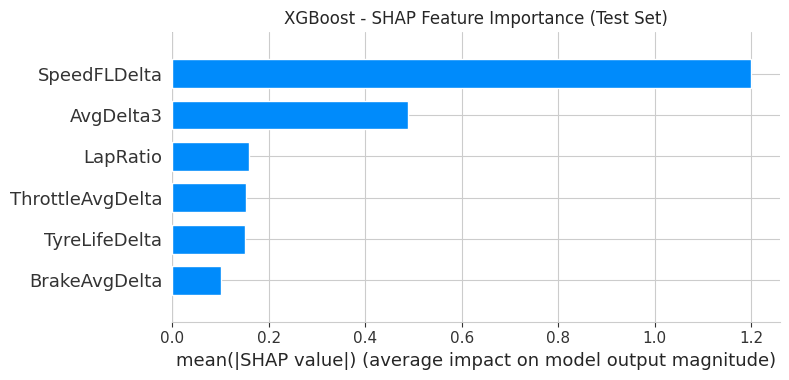

In [418]:
import shap
import matplotlib.pyplot as plt

# Initialize SHAP explainer
explainer_xgb = shap.Explainer(xgb_model)
shap_values_xgb = explainer_xgb(X_test)

# Plot summary of feature importance
plt.figure(figsize=(10, 6))
shap.summary_plot(shap_values_xgb, X_test, plot_type="bar", show=False)
plt.title("XGBoost - SHAP Feature Importance (Test Set)")
plt.tight_layout()
plt.show()



In [426]:
import pandas as pd

# Extract feature importances
feature_importances = pd.DataFrame(rf_model.feature_importances_,
                                   index = X_test.columns,
                                   columns=['Importance']).sort_values('Importance', ascending=False)

print(feature_importances)


                  Importance
SpeedFLDelta        0.652761
AvgDelta3           0.157735
LapRatio            0.065177
ThrottleAvgDelta    0.051619
BrakeAvgDelta       0.044537
TyreLifeDelta       0.028171


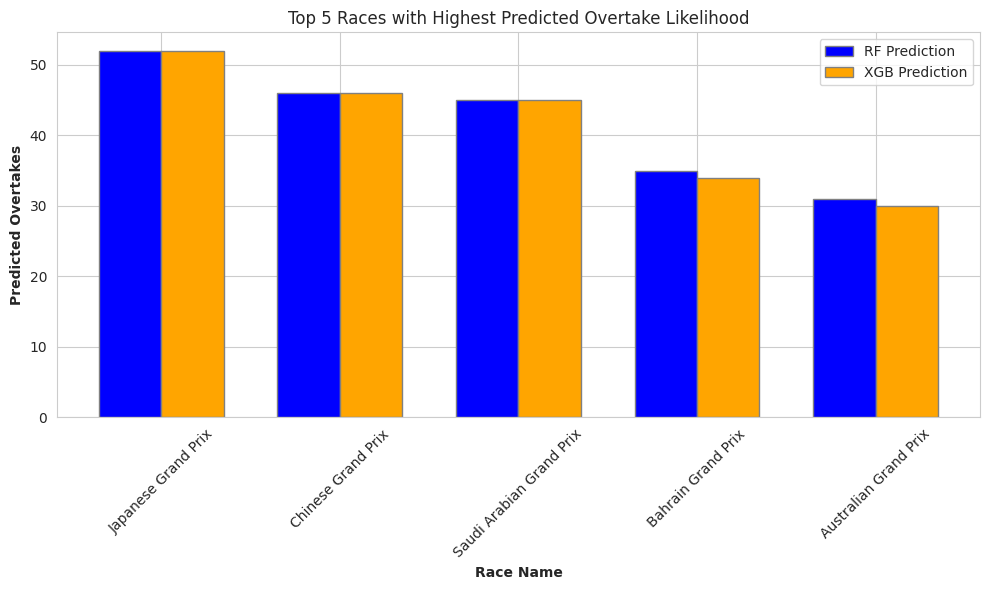

In [429]:
import matplotlib.pyplot as plt
import numpy as np

# Set the figure size
plt.figure(figsize=(10, 6))

# Set the bar width and positions
bar_width = 0.35
r1 = np.arange(len(top_5_races))
r2 = [x + bar_width for x in r1]

# Plotting the bars
plt.bar(r1, top_5_races['OvertakePrediction_RF'], color='blue', width=bar_width, edgecolor='grey', label='RF Prediction')
plt.bar(r2, top_5_races['OvertakePrediction_XGB'], color='orange', width=bar_width, edgecolor='grey', label='XGB Prediction')

# Adding labels
plt.xlabel('Race Name', fontweight='bold')
plt.ylabel('Predicted Overtakes', fontweight='bold')
plt.title('Top 5 Races with Highest Predicted Overtake Likelihood')
plt.xticks([r + bar_width / 2 for r in range(len(top_5_races))], top_5_races['RaceName'], rotation=45)
plt.legend()

# Display the plot
plt.tight_layout()
plt.show()
